## Import Libraries and Layers

In [7]:
from IPython.display import display
import arcgis
from arcgis.gis import GIS
import pandas as pd
pd.set_option('display.max_columns', 500)
from arcgis.features import FeatureLayer
from arcgis.mapping import WebMap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
gis = GIS("https://datascienceqa.esri.com/portal", "portaladmin", "esri.agp", verify_cert=False)
# gis = GIS("https://datascienceqa.esri.com/portal", "portaladmin", "esri.agp")

In [214]:
# Layers Used
# Provider data layer
provider_layer = FeatureLayer("https://datascienceqa.esri.com/server/rest/services/Hosted/provider_clean_data_geocoded_6_19/FeatureServer/0")

# Population Density
from arcgis.mapping import MapImageLayer
popdensity = MapImageLayer("https://datascienceqa.esri.com/portal/sharing/servers/ab4e1996d588405d9cd68348ef660f70/rest/services/USA_Demographics_and_Boundaries_2018/MapServer")

# Median Income
medIncome = MapImageLayer("https://datascienceqa.esri.com/portal/sharing/servers/3e5f8ebe5a114a61b7f350e7a1203761/rest/services/USA_Demographics_and_Boundaries_2018/MapServer")

# Median Age
medAge = MapImageLayer("https://datascienceqa.esri.com/portal/sharing/servers/e2558ac0c5e04235ad7820773e89d110/rest/services/USA_Demographics_and_Boundaries_2018/MapServer")

# Health Insurance Coverage
tx_insurance_state = FeatureLayer("https://services.arcgis.com/P3ePLMYs2RVChkJx/arcgis/rest/services/ACS_Health_Insurance_Boundaries/FeatureServer")
tx_insurance_county = FeatureLayer("https://services.arcgis.com/P3ePLMYs2RVChkJx/arcgis/rest/services/ACS_Health_Insurance_Boundaries/FeatureServer/1")
tx_insurance_tract = FeatureLayer("https://services.arcgis.com/P3ePLMYs2RVChkJx/arcgis/rest/services/ACS_Health_Insurance_Boundaries/FeatureServer/2")

# Fertility layers for State, County and Tract (Percent of women 15 to 50 who had a birth in the past 12 months)
fertility_state = FeatureLayer("https://services.arcgis.com/P3ePLMYs2RVChkJx/arcgis/rest/services/ACS_Fertility_by_Age_Boundaries/FeatureServer/0")
fertility_county = FeatureLayer("https://services.arcgis.com/P3ePLMYs2RVChkJx/arcgis/rest/services/ACS_Fertility_by_Age_Boundaries/FeatureServer/1")
fertility_tract = FeatureLayer("https://services.arcgis.com/P3ePLMYs2RVChkJx/arcgis/rest/services/ACS_Fertility_by_Age_Boundaries/FeatureServer/2")

In [9]:
search_result = gis.content.search('title: provider_data_geocoded_7_23', 'Feature Layer')
provider_data_item = search_result[0]
provider_data_item

<Item title:"provider_data_geocoded_7_23" type:Feature Layer Collection owner:portaladmin>

In [10]:
provider_data_layer = provider_data_item.layers[0]
provider_data_layer

<FeatureLayer url:"https://datascienceqa.esri.com/server/rest/services/Hosted/provider_data_geocoded_7_23/FeatureServer/0">

## OBGYN Providers and Other Data

#### Create df for OBGYN providers

In [12]:
# Get provider data for obgyn providers only

obgyn_featureset = provider_data_layer.query(where="user_taxonomy_code_1 in ['207V00000X','207VC0200X','207VF0040X','207VX0201X','207VG0400X','207VH0002X','207VM0101X','207VB0002X','207VX0000X','207VE0102X','363LX0001X','163WR1000X','163WW0101X','282NW0100X']", out_fields='user_npi,user_entity_type,user_provider_gender,user_taxonomy_code_1,user_full_address,Postal,City,Subregion,Region,RegionAbbr')
obgyn_df = obgyn_featureset.sdf
obgyn_df.head()

,City,OBJECTID,Postal,Region,RegionAbbr,SHAPE,Subregion,user_entity_type,user_full_address,user_npi,user_provider_gender,user_taxonomy_code_1
0,Norman,8,73072,Oklahoma,OK,"{""x"": -97.49116252599998, ""y"": 35.261905469000...",Cleveland County,Individual,"3400 W TECUMSEH RD, SUITE 205, NORMAN, OK 7307...",1487657532,F,207V00000X
1,Sunnyside,24,98944,Washington,WA,"{""x"": -120.00990533799995, ""y"": 46.31641132900...",Yakima County,Individual,"803 E LINCOLN AVE, , SUNNYSIDE, WA 989442383",1265435218,F,207V00000X
2,Charleston,26,25302,West Virginia,WV,"{""x"": -81.63739261199999, ""y"": 38.359802984000...",Kanawha County,Individual,"830 PENNSYLVANIA AVE, SUITE 108, CHARLESTON, W...",1447253497,M,207V00000X
3,Charleston,99,25302,West Virginia,WV,"{""x"": -81.63739261199999, ""y"": 38.359802984000...",Kanawha County,Individual,"830 PENNSYLVANIA AVE, STE 402, CHARLESTON, WV ...",1487657631,M,207V00000X
4,Charleston,172,25302,West Virginia,WV,"{""x"": -81.63739261199999, ""y"": 38.359802984000...",Kanawha County,Individual,"830 PENNSYLVANIA AVE, STE 402, CHARLESTON, WV ...",1255334405,M,207V00000X


In [307]:
obgyn_df.shape

(66754, 12)

In [13]:
obgyn_county_df = obgyn_df[['RegionAbbr','Subregion']]
obgyn_county_df['Provider_Count'] = obgyn_county_df.groupby(['RegionAbbr','Subregion'])['Subregion'].transform('count')
obgyn_count_df = obgyn_county_df.drop_duplicates(subset='Subregion', keep="first", inplace=True)
obgyn_county_df.shape

C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


(1282, 3)

In [14]:
obgyn_county_df = obgyn_county_df.sort_values(by=['Provider_Count'], ascending=False)
obgyn_county_df.head()

,RegionAbbr,Subregion,Provider_Count
99,CA,Los Angeles County,2094
34,IL,Cook County,1586
1227,NY,New York County,1136
7,TX,Harris County,1124
130,AZ,Maricopa County,844


In [15]:
# Check missing
obgyn_county_df.isnull().sum()

RegionAbbr        0
Subregion         0
Provider_Count    0
dtype: int64

#### Create County df from Demographics Data

In [16]:
# Search for Population data layer
popsearch_result = gis.content.search('title: 2018 USA Population Density')
popsearch_result

[<Item title:"2018 USA Tapestry Segmentation" type:Map Image Layer owner:esri_livingatlas>,
 <Item title:"2018 USA Population Density" type:Map Image Layer owner:esri_livingatlas>]

<Item title:"2018 USA Population Density" type:Map Image Layer owner:esri_livingatlas>
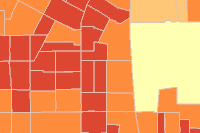

In [17]:
# Get Population Density
popdensity = popsearch_result[1]
popdensity

In [19]:
# Check all layers in population Density
popdensity.layers

[<FeatureLayer url:"https://datascienceqa.esri.com/portal/sharing/servers/ab4e1996d588405d9cd68348ef660f70/rest/services/USA_Demographics_and_Boundaries_2018/MapServer/0">,
 <FeatureLayer url:"https://datascienceqa.esri.com/portal/sharing/servers/ab4e1996d588405d9cd68348ef660f70/rest/services/USA_Demographics_and_Boundaries_2018/MapServer/1">,
 <FeatureLayer url:"https://datascienceqa.esri.com/portal/sharing/servers/ab4e1996d588405d9cd68348ef660f70/rest/services/USA_Demographics_and_Boundaries_2018/MapServer/2">,
 <FeatureLayer url:"https://datascienceqa.esri.com/portal/sharing/servers/ab4e1996d588405d9cd68348ef660f70/rest/services/USA_Demographics_and_Boundaries_2018/MapServer/3">,
 <FeatureLayer url:"https://datascienceqa.esri.com/portal/sharing/servers/ab4e1996d588405d9cd68348ef660f70/rest/services/USA_Demographics_and_Boundaries_2018/MapServer/4">,
 <FeatureLayer url:"https://datascienceqa.esri.com/portal/sharing/servers/ab4e1996d588405d9cd68348ef660f70/rest/services/USA_Demographi

In [20]:
# county_layer = FeatureLayer("https://datascienceqa.esri.com/portal/sharing/servers/3e5f8ebe5a114a61b7f350e7a1203761/rest/services/USA_Demographics_and_Boundaries_2018/MapServer/46")
county_layer = popdensity.layers[46]
county_df = pd.DataFrame()
offset = 0
while offset <= 3000:
    county_featureset_test = county_layer.query(return_all_records=False,
                                           result_offset=offset,
                                           result_record_count=750)
    county_df_test = county_featureset_test.sdf
    county_df = pd.concat([county_df_test, county_df], ignore_index=True)
    offset += 750

In [21]:
county_df.shape

(3142, 1943)

In [22]:
for field in county_layer.properties.fields:
#     print(field)
    print(field['name'], '\t', field['alias'])
#     print(field[0])

OBJECTID 	 OBJECTID
Shape 	 Shape
ID 	 ID
NAME 	 NAME
STATE_NAME 	 STATE_NAME
ST_ABBREV 	 ST_ABBREV
AREA 	 Area in Square Miles (Calculated)
TOTPOP_CY 	 2018 Total Population (Esri)
HHPOP_CY 	 2018 Household Population (Esri)
FAMPOP_CY 	 2018 Family Population (Esri)
GQPOP_CY 	 2018 Group Quarters Population (Esri)
POPDENS_CY 	 2018 Population Density (Pop per Square Mile) (Esri)
TOTHH_CY 	 2018 Total Households (Esri)
AVGHHSZ_CY 	 2018 Average Household Size (Esri)
FAMHH_CY 	 2018 Total Family Households (Esri)
AVGFMSZ_CY 	 2018 Average Family Size (Esri)
TOTHU_CY 	 2018 Total Housing Units (Esri)
OWNER_CY 	 2018 Owner Occupied Housing Units (Esri)
RENTER_CY 	 2018 Renter Occupied Housing Units (Esri)
VACANT_CY 	 2018 Vacant Housing Units (Esri)
POPGRW10CY 	 2010-2018 Population: Annual Growth Rate (Esri)
HHGRW10CY 	 2010-2018 Households: Annual Growth Rate (Esri)
FAMGRW10CY 	 2010-2018 Families: Annual Growth Rate (Esri)
GENALPHACY 	 2018 Generation Alpha Population (Born 2017 or Lat

FAGE38_FY 	 2023 Female Population Age 38 (Esri)
FAGE39_FY 	 2023 Female Population Age 39 (Esri)
FAGE40_FY 	 2023 Female Population Age 40 (Esri)
FAGE41_FY 	 2023 Female Population Age 41 (Esri)
FAGE42_FY 	 2023 Female Population Age 42 (Esri)
FAGE43_FY 	 2023 Female Population Age 43 (Esri)
FAGE44_FY 	 2023 Female Population Age 44 (Esri)
FAGE45_FY 	 2023 Female Population Age 45 (Esri)
FAGE46_FY 	 2023 Female Population Age 46 (Esri)
FAGE47_FY 	 2023 Female Population Age 47 (Esri)
FAGE48_FY 	 2023 Female Population Age 48 (Esri)
FAGE49_FY 	 2023 Female Population Age 49 (Esri)
FAGE50_FY 	 2023 Female Population Age 50 (Esri)
FAGE51_FY 	 2023 Female Population Age 51 (Esri)
FAGE52_FY 	 2023 Female Population Age 52 (Esri)
FAGE53_FY 	 2023 Female Population Age 53 (Esri)
FAGE54_FY 	 2023 Female Population Age 54 (Esri)
FAGE55_FY 	 2023 Female Population Age 55 (Esri)
FAGE56_FY 	 2023 Female Population Age 56 (Esri)
FAGE57_FY 	 2023 Female Population Age 57 (Esri)
FAGE58_FY 	 2023 Fem

In [23]:
# Removing columns for 2023,2010,2000
county_df = county_df.loc[:,~county_df.columns.str.contains('FY|10|00')]
len(county_df.columns)

894

In [24]:
# Removing columns for individual age
county_df = county_df.loc[:,~county_df.columns.str.startswith(('AGE','MAGE','FAGE'))]
len(county_df.columns)

640

In [25]:
# Removing columns for Industry, Occupation
county_df = county_df.loc[:,~county_df.columns.str.startswith(('IND','OCC'))]
len(county_df.columns)

596

In [26]:
# Removing Individual Income Columns
county_df = county_df.loc[:,~county_df.columns.str.contains('A15|A25|A35|A45|A55|A65|A75')]
len(county_df.columns)

366

In [27]:
# Removing columns for Disposable Income and Net Worth
county_df = county_df.loc[:,~county_df.columns.str.startswith(('DI','NW'))]
len(county_df.columns)

348

In [28]:
# Removing columns for Tapestry Segmentation
county_df = county_df.loc[:,~county_df.columns.str.startswith(('TSE','THH','TADULT'))]
len(county_df.columns)

190

In [29]:
# Removing columns for Home Value
county_df = county_df.loc[:,~county_df.columns.str.startswith(('VAL'))]
len(county_df.columns)

181

In [30]:
county_df.columns

Index(['AAGEBASECY', 'AGGDI_CY', 'AGGHINC_CY', 'AGGINC_CY', 'AGGNW_CY',
       'AIFBASE_CY', 'AIMBASE_CY', 'AMERIND_CY', 'AREA', 'ASIAN_CY',
       ...
       'TOTHU_CY', 'TOTPOP_CY', 'UNEMPRT_CY', 'UNEMP_CY', 'VACANT_CY',
       'WAGEBASECY', 'WHITE_CY', 'WHTFBASECY', 'WHTMBASECY', 'WIDOWED_CY'],
      dtype='object', length=181)

In [31]:
print(obgyn_county_df.shape)
print(county_df.shape)

(1282, 3)
(3142, 181)


#### Merge dataframes

In [32]:
# Merge provider count and women_df at state level
newcounty_obgyn_df = pd.merge(obgyn_county_df,county_df,left_on=['RegionAbbr','Subregion'], right_on=['ST_ABBREV','NAME'],how='left')

In [33]:
newcounty_obgyn_df.shape

(1282, 184)

In [34]:
test_newcounty_df = newcounty_obgyn_df.copy()
test_newcounty_df.head()

,RegionAbbr,Subregion,Provider_Count,AAGEBASECY,AGGDI_CY,AGGHINC_CY,AGGINC_CY,AGGNW_CY,AIFBASE_CY,AIMBASE_CY,AMERIND_CY,AREA,ASIAN_CY,ASNFBASECY,ASNMBASECY,ASSCDEG_CY,AVGDI_CY,AVGFMSZ_CY,AVGHHSZ_CY,AVGHINC_CY,AVGNW_CY,AVGVAL_CY,BABYBOOMCY,BACHDEG_CY,BAGEBASECY,BLACK_CY,BLKFBASECY,BLKMBASECY,CIVLBFR_CY,EDUCBASECY,EMP_CY,FAMHH_CY,FAMPOP_CY,FEM0_CY,FEM15_CY,FEM18UP_CY,FEM20_CY,FEM21UP_CY,FEM25_CY,FEM30_CY,FEM35_CY,FEM40_CY,FEM45_CY,FEM50_CY,FEM55_CY,FEM5_CY,FEM60_CY,FEM65_CY,FEM70_CY,FEM75_CY,FEM80_CY,FEM85_CY,FEMALES_CY,GED_CY,GENALPHACY,GENBASE_CY,GENX_CY,GENZ_CY,GQPOP_CY,GRADDEG_CY,HAGEBASECY,HHPOP_CY,HINC0_CY,HINC150_CY,HINC15_CY,HINC25_CY,HINC35_CY,HINC50_CY,HINC75_CY,HINCBASECY,HISPAI_CY,HISPASN_CY,HISPBLK_CY,HISPMLT_CY,HISPOTH_CY,HISPPI_CY,HISPPOP_CY,HISPWHT_CY,HSGRAD_CY,HSPFBASECY,HSPMBASECY,IAGEBASECY,ID,LANDAREA,MAL18UP_CY,MAL21UP_CY,MALE0_CY,MALE15_CY,MALE20_CY,MALE25_CY,MALE30_CY,MALE35_CY,MALE40_CY,MALE45_CY,MALE50_CY,MALE55_CY,MALE5_CY,MALE60_CY,MALE65_CY,MALE70_CY,MALE75_CY,MALE80_CY,MALE85_CY,MALES_CY,MARBASE_CY,MARRIED_CY,MEDAGE_CY,MEDDI_CY,MEDFAGE_CY,MEDHHR_CY,MEDHINC_CY,MEDMAGE_CY,MEDNW_CY,MEDVAL_CY,MILLENN_CY,MINORITYCY,MLTFBASECY,MLTMBASECY,NAME,NEVMARR_CY,NHSPAI_CY,NHSPASN_CY,NHSPBLK_CY,NHSPMLT_CY,NHSPOTH_CY,NHSPPI_CY,NHSPWHT_CY,NOHS_CY,NONHISP_CY,OAGEBASECY,OBJECTID,OLDRGENSCY,OTHFBASECY,OTHMBASECY,OTHRACE_CY,OWNER_CY,PACIFIC_CY,PAGEBASECY,PCI_CY,PIFBASE_CY,PIMBASE_CY,POP0_CY,POP15_CY,POP18UP_CY,POP20_CY,POP21UP_CY,POP25_CY,POP30_CY,POP35_CY,POP40_CY,POP45_CY,POP50_CY,POP55_CY,POP5_CY,POP60_CY,POP65_CY,POP70_CY,POP75_CY,POP80_CY,POP85_CY,POPDENS_CY,RACE2UP_CY,RACEBASECY,RENTER_CY,SHAPE,SMCOLL_CY,SOMEHS_CY,STATE_NAME,ST_ABBREV,Shape_Area,Shape_Length,TLIFECODE,TLIFENAME,TOTHH_CY,TOTHU_CY,TOTPOP_CY,UNEMPRT_CY,UNEMP_CY,VACANT_CY,WAGEBASECY,WHITE_CY,WHTFBASECY,WHTMBASECY,WIDOWED_CY
0,CA,Los Angeles County,2094,1517296.0,2.359152e+11,3.196410e+11,3.247511e+11,2.224411e+12,35957.0,37602.0,73559.0,4085.699440,1517296.0,805865.0,711431.0,469649.0,70013.0,3.63,3.00,94861.0,660145.0,710686.0,1987624.0,1445895.0,850350.0,850350.0,450243.0,400107.0,5232399.0,6899087.0,4995839.0,2281483.0,8292844.0,312953.0,331081.0,4077284.0,384255.0,3858162.0,421330.0,392960.0,359612.0,328513.0,335961.0,332084.0,327978.0,310887.0,291733.0,246493.0,183490.0,131256.0,90178.0,110499.0,5208957.0,120351.0,255399.0,10288937.0,2130083.0,2353920.0,176419.0,782758.0,5043293.0,10112518.0,371190.0,243110.0,310104.0,280437.0,390334.0,554983.0,394431.0,3369582.0,54769.0,22824.0,45013.0,261906.0,2280356.0,3826.0,5043293.0,2374599.0,1288396.0,2522627.0,2520666.0,73559.0,06037,4057.8835,3890494.0,3663128.0,326230.0,351424.0,396276.0,433863.0,402148.0,368194.0,325765.0,331204.0,323486.0,307396.0,325231.0,261725.0,209710.0,149559.0,102402.0,65741.0,65807.0,5079980.0,8362123.0,3752436.0,35.7,52454.0,36.9,50.6,62751.0,34.6,60024.0,569360.0,2875966.0,7644196.0,251940.0,244185.0,Los Angeles County,3521307.0,18790.0,1494472.0,805337.0,234219.0,24674.0,23411.0,2644741.0,878838.0,5245644.0,2305030.0,205.0,685945.0,1141774.0,1163256.0,2305030.0,1538585.0,27237.0,27237.0,31563.0,13746.0,13491.0,639183.0,682505.0,7967778.0,780531.0,7521290.0,855193.0,795108.0,727806.0,654278.0,667165.0,655570.0,635374.0,636118.0,553458.0,456203.0,333049.0,233658.0,155919.0,176306.0,2535.5,496125.0,10288937.0,1831065.0,"{'rings': [[[-13201886.423700001, 3900000.9334...",1300786.0,612414.0,California,CA,1.553815e+10,9.723835e+05,13,Next Wave,3369650.0,3576478.0,10288937.0,4.5,236560.0,206828.0,5019340.0,5019340.0,2509432.0,2509908.0,413837.0
1,IL,Cook County,1586,395712.0,1.284204e+11,1.771502e+11,1.797564e+11,1.326345e+12,10418.0,10695.0,21113.0,953.145682,395712.0,206041.0,189671.0,237028.0,63978.0,3.36,2.58,88254.0,660769.0,335311.0,1076607.0,830433.0,1233716.0,1233716.0,674544.0,559172.0,2791109.0,3607345.0,2599303.0,1216270.0,4087547.0,158205.0,161652.0,2144742.0,185272.0,2040962.0,217698.0,207243.0,188312.0,166222.0,164629.0,166570.0,174115.0,159117.0,162326.0,139839.0,10462

In [35]:
test_newcounty_df.drop(['OBJECTID','SHAPE','STATE_NAME','ST_ABBREV','NAME','Shape_Area','Shape_Length','TLIFENAME','ID','TLIFECODE'], axis=1, inplace=True)
test_newcounty_df.head()

,RegionAbbr,Subregion,Provider_Count,AAGEBASECY,AGGDI_CY,AGGHINC_CY,AGGINC_CY,AGGNW_CY,AIFBASE_CY,AIMBASE_CY,AMERIND_CY,AREA,ASIAN_CY,ASNFBASECY,ASNMBASECY,ASSCDEG_CY,AVGDI_CY,AVGFMSZ_CY,AVGHHSZ_CY,AVGHINC_CY,AVGNW_CY,AVGVAL_CY,BABYBOOMCY,BACHDEG_CY,BAGEBASECY,BLACK_CY,BLKFBASECY,BLKMBASECY,CIVLBFR_CY,EDUCBASECY,EMP_CY,FAMHH_CY,FAMPOP_CY,FEM0_CY,FEM15_CY,FEM18UP_CY,FEM20_CY,FEM21UP_CY,FEM25_CY,FEM30_CY,FEM35_CY,FEM40_CY,FEM45_CY,FEM50_CY,FEM55_CY,FEM5_CY,FEM60_CY,FEM65_CY,FEM70_CY,FEM75_CY,FEM80_CY,FEM85_CY,FEMALES_CY,GED_CY,GENALPHACY,GENBASE_CY,GENX_CY,GENZ_CY,GQPOP_CY,GRADDEG_CY,HAGEBASECY,HHPOP_CY,HINC0_CY,HINC150_CY,HINC15_CY,HINC25_CY,HINC35_CY,HINC50_CY,HINC75_CY,HINCBASECY,HISPAI_CY,HISPASN_CY,HISPBLK_CY,HISPMLT_CY,HISPOTH_CY,HISPPI_CY,HISPPOP_CY,HISPWHT_CY,HSGRAD_CY,HSPFBASECY,HSPMBASECY,IAGEBASECY,LANDAREA,MAL18UP_CY,MAL21UP_CY,MALE0_CY,MALE15_CY,MALE20_CY,MALE25_CY,MALE30_CY,MALE35_CY,MALE40_CY,MALE45_CY,MALE50_CY,MALE55_CY,MALE5_CY,MALE60_CY,MALE65_CY,MALE70_CY,MALE75_CY,MALE80_CY,MALE85_CY,MALES_CY,MARBASE_CY,MARRIED_CY,MEDAGE_CY,MEDDI_CY,MEDFAGE_CY,MEDHHR_CY,MEDHINC_CY,MEDMAGE_CY,MEDNW_CY,MEDVAL_CY,MILLENN_CY,MINORITYCY,MLTFBASECY,MLTMBASECY,NEVMARR_CY,NHSPAI_CY,NHSPASN_CY,NHSPBLK_CY,NHSPMLT_CY,NHSPOTH_CY,NHSPPI_CY,NHSPWHT_CY,NOHS_CY,NONHISP_CY,OAGEBASECY,OLDRGENSCY,OTHFBASECY,OTHMBASECY,OTHRACE_CY,OWNER_CY,PACIFIC_CY,PAGEBASECY,PCI_CY,PIFBASE_CY,PIMBASE_CY,POP0_CY,POP15_CY,POP18UP_CY,POP20_CY,POP21UP_CY,POP25_CY,POP30_CY,POP35_CY,POP40_CY,POP45_CY,POP50_CY,POP55_CY,POP5_CY,POP60_CY,POP65_CY,POP70_CY,POP75_CY,POP80_CY,POP85_CY,POPDENS_CY,RACE2UP_CY,RACEBASECY,RENTER_CY,SMCOLL_CY,SOMEHS_CY,TOTHH_CY,TOTHU_CY,TOTPOP_CY,UNEMPRT_CY,UNEMP_CY,VACANT_CY,WAGEBASECY,WHITE_CY,WHTFBASECY,WHTMBASECY,WIDOWED_CY
0,CA,Los Angeles County,2094,1517296.0,2.359152e+11,3.196410e+11,3.247511e+11,2.224411e+12,35957.0,37602.0,73559.0,4085.699440,1517296.0,805865.0,711431.0,469649.0,70013.0,3.63,3.00,94861.0,660145.0,710686.0,1987624.0,1445895.0,850350.0,850350.0,450243.0,400107.0,5232399.0,6899087.0,4995839.0,2281483.0,8292844.0,312953.0,331081.0,4077284.0,384255.0,3858162.0,421330.0,392960.0,359612.0,328513.0,335961.0,332084.0,327978.0,310887.0,291733.0,246493.0,183490.0,131256.0,90178.0,110499.0,5208957.0,120351.0,255399.0,10288937.0,2130083.0,2353920.0,176419.0,782758.0,5043293.0,10112518.0,371190.0,243110.0,310104.0,280437.0,390334.0,554983.0,394431.0,3369582.0,54769.0,22824.0,45013.0,261906.0,2280356.0,3826.0,5043293.0,2374599.0,1288396.0,2522627.0,2520666.0,73559.0,4057.8835,3890494.0,3663128.0,326230.0,351424.0,396276.0,433863.0,402148.0,368194.0,325765.0,331204.0,323486.0,307396.0,325231.0,261725.0,209710.0,149559.0,102402.0,65741.0,65807.0,5079980.0,8362123.0,3752436.0,35.7,52454.0,36.9,50.6,62751.0,34.6,60024.0,569360.0,2875966.0,7644196.0,251940.0,244185.0,3521307.0,18790.0,1494472.0,805337.0,234219.0,24674.0,23411.0,2644741.0,878838.0,5245644.0,2305030.0,685945.0,1141774.0,1163256.0,2305030.0,1538585.0,27237.0,27237.0,31563.0,13746.0,13491.0,639183.0,682505.0,7967778.0,780531.0,7521290.0,855193.0,795108.0,727806.0,654278.0,667165.0,655570.0,635374.0,636118.0,553458.0,456203.0,333049.0,233658.0,155919.0,176306.0,2535.5,496125.0,10288937.0,1831065.0,1300786.0,612414.0,3369650.0,3576478.0,10288937.0,4.5,236560.0,206828.0,5019340.0,5019340.0,2509432.0,2509908.0,413837.0
1,IL,Cook County,1586,395712.0,1.284204e+11,1.771502e+11,1.797564e+11,1.326345e+12,10418.0,10695.0,21113.0,953.145682,395712.0,206041.0,189671.0,237028.0,63978.0,3.36,2.58,88254.0,660769.0,335311.0,1076607.0,830433.0,1233716.0,1233716.0,674544.0,559172.0,2791109.0,3607345.0,2599303.0,1216270.0,4087547.0,158205.0,161652.0,2144742.0,185272.0,2040962.0,217698.0,207243.0,188312.0,166222.0,164629.0,166570.0,174115.0,159117.0,162326.0,139839.0,104629.0,75554.0,54048.0,70522.0,2717277.0,95959.0,129327.0,5274129.0,1058747.0,1171989.0,90942.0,552050.0,1374256.0,5183187.0,250519.0,132865.0,186804.0,169815.0,238778.0,329118.0,243670.0,2007274.0,15131.0,4083.0,22733.0,66348.

In [334]:
# Change Provider Count to Float
# test_newcounty_df['Provider_Count'] = test_newstate_df['Provider_Count'].astype(float)

In [36]:
test_newcounty_df

,RegionAbbr,Subregion,Provider_Count,AAGEBASECY,AGGDI_CY,AGGHINC_CY,AGGINC_CY,AGGNW_CY,AIFBASE_CY,AIMBASE_CY,AMERIND_CY,AREA,ASIAN_CY,ASNFBASECY,ASNMBASECY,ASSCDEG_CY,AVGDI_CY,AVGFMSZ_CY,AVGHHSZ_CY,AVGHINC_CY,AVGNW_CY,AVGVAL_CY,BABYBOOMCY,BACHDEG_CY,BAGEBASECY,BLACK_CY,BLKFBASECY,BLKMBASECY,CIVLBFR_CY,EDUCBASECY,EMP_CY,FAMHH_CY,FAMPOP_CY,FEM0_CY,FEM15_CY,FEM18UP_CY,FEM20_CY,FEM21UP_CY,FEM25_CY,FEM30_CY,FEM35_CY,FEM40_CY,FEM45_CY,FEM50_CY,FEM55_CY,FEM5_CY,FEM60_CY,FEM65_CY,FEM70_CY,FEM75_CY,FEM80_CY,FEM85_CY,FEMALES_CY,GED_CY,GENALPHACY,GENBASE_CY,GENX_CY,GENZ_CY,GQPOP_CY,GRADDEG_CY,HAGEBASECY,HHPOP_CY,HINC0_CY,HINC150_CY,HINC15_CY,HINC25_CY,HINC35_CY,HINC50_CY,HINC75_CY,HINCBASECY,HISPAI_CY,HISPASN_CY,HISPBLK_CY,HISPMLT_CY,HISPOTH_CY,HISPPI_CY,HISPPOP_CY,HISPWHT_CY,HSGRAD_CY,HSPFBASECY,HSPMBASECY,IAGEBASECY,LANDAREA,MAL18UP_CY,MAL21UP_CY,MALE0_CY,MALE15_CY,MALE20_CY,MALE25_CY,MALE30_CY,MALE35_CY,MALE40_CY,MALE45_CY,MALE50_CY,MALE55_CY,MALE5_CY,MALE60_CY,MALE65_CY,MALE70_CY,MALE75_CY,MALE80_CY,MALE85_CY,MALES_CY,MARBASE_CY,MARRIED_CY,MEDAGE_CY,MEDDI_CY,MEDFAGE_CY,MEDHHR_CY,MEDHINC_CY,MEDMAGE_CY,MEDNW_CY,MEDVAL_CY,MILLENN_CY,MINORITYCY,MLTFBASECY,MLTMBASECY,NEVMARR_CY,NHSPAI_CY,NHSPASN_CY,NHSPBLK_CY,NHSPMLT_CY,NHSPOTH_CY,NHSPPI_CY,NHSPWHT_CY,NOHS_CY,NONHISP_CY,OAGEBASECY,OLDRGENSCY,OTHFBASECY,OTHMBASECY,OTHRACE_CY,OWNER_CY,PACIFIC_CY,PAGEBASECY,PCI_CY,PIFBASE_CY,PIMBASE_CY,POP0_CY,POP15_CY,POP18UP_CY,POP20_CY,POP21UP_CY,POP25_CY,POP30_CY,POP35_CY,POP40_CY,POP45_CY,POP50_CY,POP55_CY,POP5_CY,POP60_CY,POP65_CY,POP70_CY,POP75_CY,POP80_CY,POP85_CY,POPDENS_CY,RACE2UP_CY,RACEBASECY,RENTER_CY,SMCOLL_CY,SOMEHS_CY,TOTHH_CY,TOTHU_CY,TOTPOP_CY,UNEMPRT_CY,UNEMP_CY,VACANT_CY,WAGEBASECY,WHITE_CY,WHTFBASECY,WHTMBASECY,WIDOWED_CY
0,CA,Los Angeles County,2094,1517296.0,2.359152e+11,3.196410e+11,3.247511e+11,2.224411e+12,35957.0,37602.0,73559.0,4085.699440,1517296.0,805865.0,711431.0,469649.0,70013.0,3.63,3.00,94861.0,660145.0,710686.0,1987624.0,1445895.0,850350.0,850350.0,450243.0,400107.0,5232399.0,6899087.0,4995839.0,2281483.0,8292844.0,312953.0,331081.0,4077284.0,384255.0,3858162.0,421330.0,392960.0,359612.0,328513.0,335961.0,332084.0,327978.0,310887.0,291733.0,246493.0,183490.0,131256.0,90178.0,110499.0,5208957.0,120351.0,255399.0,10288937.0,2130083.0,2353920.0,176419.0,782758.0,5043293.0,10112518.0,371190.0,243110.0,310104.0,280437.0,390334.0,554983.0,394431.0,3369582.0,54769.0,22824.0,45013.0,261906.0,2280356.0,3826.0,5043293.0,2374599.0,1288396.0,2522627.0,2520666.0,73559.0,4057.8835,3890494.0,3663128.0,326230.0,351424.0,396276.0,433863.0,402148.0,368194.0,325765.0,331204.0,323486.0,307396.0,325231.0,261725.0,209710.0,149559.0,102402.0,65741.0,65807.0,5079980.0,8362123.0,3752436.0,35.7,52454.0,36.9,50.6,62751.0,34.6,60024.0,569360.0,2875966.0,7644196.0,251940.0,244185.0,3521307.0,18790.0,1494472.0,805337.0,234219.0,24674.0,23411.0,2644741.0,878838.0,5245644.0,2305030.0,685945.0,1141774.0,1163256.0,2305030.0,1538585.0,27237.0,27237.0,31563.0,13746.0,13491.0,639183.0,682505.0,7967778.0,780531.0,7521290.0,855193.0,795108.0,727806.0,654278.0,667165.0,655570.0,635374.0,636118.0,553458.0,456203.0,333049.0,233658.0,155919.0,176306.0,2535.5,496125.0,10288937.0,1831065.0,1300786.0,612414.0,3369650.0,3576478.0,10288937.0,4.5,236560.0,206828.0,5019340.0,5019340.0,2509432.0,2509908.0,413837.0
1,IL,Cook County,1586,395712.0,1.284204e+11,1.771502e+11,1.797564e+11,1.326345e+12,10418.0,10695.0,21113.0,953.145682,395712.0,206041.0,189671.0,237028.0,63978.0,3.36,2.58,88254.0,660769.0,335311.0,1076607.0,830433.0,1233716.0,1233716.0,674544.0,559172.0,2791109.0,3607345.0,2599303.0,1216270.0,4087547.0,158205.0,161652.0,2144742.0,185272.0,2040962.0,217698.0,207243.0,188312.0,166222.0,164629.0,166570.0,174115.0,159117.0,162326.0,139839.0,104629.0,75554.0,54048.0,70522.0,2717277.0,95959.0,129327.0,5274129.0,1058747.0,1171989.0,90942.0,552050.0,1374256.0,5183187.0,250519.0,132865.0,186804.0,169815.0,238778.0,329118.0,243670.0,2007274.0,15131.0,4083.0,22733.0,66348.

### Missing Values

In [37]:
# Any missing values in the data
test_newcounty_df.isnull().sum().sum()

21375

In [38]:
# Columns with missing values
test_newcounty_df.isnull().sum()

RegionAbbr          0
Subregion           0
Provider_Count      0
AAGEBASECY        125
AGGDI_CY          125
AGGHINC_CY        125
AGGINC_CY         125
AGGNW_CY          125
AIFBASE_CY        125
AIMBASE_CY        125
AMERIND_CY        125
AREA              125
ASIAN_CY          125
ASNFBASECY        125
ASNMBASECY        125
ASSCDEG_CY        125
AVGDI_CY          125
AVGFMSZ_CY        125
AVGHHSZ_CY        125
AVGHINC_CY        125
AVGNW_CY          125
AVGVAL_CY         125
BABYBOOMCY        125
BACHDEG_CY        125
BAGEBASECY        125
BLACK_CY          125
BLKFBASECY        125
BLKMBASECY        125
CIVLBFR_CY        125
EDUCBASECY        125
                 ... 
POP30_CY          125
POP35_CY          125
POP40_CY          125
POP45_CY          125
POP50_CY          125
POP55_CY          125
POP5_CY           125
POP60_CY          125
POP65_CY          125
POP70_CY          125
POP75_CY          125
POP80_CY          125
POP85_CY          125
POPDENS_CY        125
RACE2UP_CY

In [39]:
# Dataframe of rows and columns with null
null_data = test_newcounty_df[test_newcounty_df.isnull().any(axis=1)]
null_data.head()

,RegionAbbr,Subregion,Provider_Count,AAGEBASECY,AGGDI_CY,AGGHINC_CY,AGGINC_CY,AGGNW_CY,AIFBASE_CY,AIMBASE_CY,AMERIND_CY,AREA,ASIAN_CY,ASNFBASECY,ASNMBASECY,ASSCDEG_CY,AVGDI_CY,AVGFMSZ_CY,AVGHHSZ_CY,AVGHINC_CY,AVGNW_CY,AVGVAL_CY,BABYBOOMCY,BACHDEG_CY,BAGEBASECY,BLACK_CY,BLKFBASECY,BLKMBASECY,CIVLBFR_CY,EDUCBASECY,EMP_CY,FAMHH_CY,FAMPOP_CY,FEM0_CY,FEM15_CY,FEM18UP_CY,FEM20_CY,FEM21UP_CY,FEM25_CY,FEM30_CY,FEM35_CY,FEM40_CY,FEM45_CY,FEM50_CY,FEM55_CY,FEM5_CY,FEM60_CY,FEM65_CY,FEM70_CY,FEM75_CY,FEM80_CY,FEM85_CY,FEMALES_CY,GED_CY,GENALPHACY,GENBASE_CY,GENX_CY,GENZ_CY,GQPOP_CY,GRADDEG_CY,HAGEBASECY,HHPOP_CY,HINC0_CY,HINC150_CY,HINC15_CY,HINC25_CY,HINC35_CY,HINC50_CY,HINC75_CY,HINCBASECY,HISPAI_CY,HISPASN_CY,HISPBLK_CY,HISPMLT_CY,HISPOTH_CY,HISPPI_CY,HISPPOP_CY,HISPWHT_CY,HSGRAD_CY,HSPFBASECY,HSPMBASECY,IAGEBASECY,LANDAREA,MAL18UP_CY,MAL21UP_CY,MALE0_CY,MALE15_CY,MALE20_CY,MALE25_CY,MALE30_CY,MALE35_CY,MALE40_CY,MALE45_CY,MALE50_CY,MALE55_CY,MALE5_CY,MALE60_CY,MALE65_CY,MALE70_CY,MALE75_CY,MALE80_CY,MALE85_CY,MALES_CY,MARBASE_CY,MARRIED_CY,MEDAGE_CY,MEDDI_CY,MEDFAGE_CY,MEDHHR_CY,MEDHINC_CY,MEDMAGE_CY,MEDNW_CY,MEDVAL_CY,MILLENN_CY,MINORITYCY,MLTFBASECY,MLTMBASECY,NEVMARR_CY,NHSPAI_CY,NHSPASN_CY,NHSPBLK_CY,NHSPMLT_CY,NHSPOTH_CY,NHSPPI_CY,NHSPWHT_CY,NOHS_CY,NONHISP_CY,OAGEBASECY,OLDRGENSCY,OTHFBASECY,OTHMBASECY,OTHRACE_CY,OWNER_CY,PACIFIC_CY,PAGEBASECY,PCI_CY,PIFBASE_CY,PIMBASE_CY,POP0_CY,POP15_CY,POP18UP_CY,POP20_CY,POP21UP_CY,POP25_CY,POP30_CY,POP35_CY,POP40_CY,POP45_CY,POP50_CY,POP55_CY,POP5_CY,POP60_CY,POP65_CY,POP70_CY,POP75_CY,POP80_CY,POP85_CY,POPDENS_CY,RACE2UP_CY,RACEBASECY,RENTER_CY,SMCOLL_CY,SOMEHS_CY,TOTHH_CY,TOTHU_CY,TOTPOP_CY,UNEMPRT_CY,UNEMP_CY,VACANT_CY,WAGEBASECY,WHITE_CY,WHTFBASECY,WHTMBASECY,WIDOWED_CY
29,CA,City and County of San Francisco,330,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30,CA,Sacramento,329,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35,MD,City of Baltimore,298,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39,HI,City and County of Honolulu,286,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [40]:
null_data.shape

(125, 174)

In [41]:
# Rows where all columns (except region, subregion, Provider Count) are null
test_newcounty_df.index[test_newcounty_df.iloc[:,3:].isnull().all(1)]

Int64Index([  29,   30,   35,   39,   48,   70,   77,  128,  133,  158,
            ...
            1248, 1249, 1253, 1256, 1265, 1270, 1272, 1273, 1278, 1279],
           dtype='int64', length=125)

In [42]:
test_newcounty_df.dropna(inplace=True)

In [43]:
test_newcounty_df.isnull().sum().sum()

0

## Run models

### Define Response and Predictor Variables

In [44]:
# Create prdictor and response variables
train_x = test_newcounty_df.iloc[:,3:]
train_y = test_newcounty_df.iloc[:,2]
train_x.head()

,AAGEBASECY,AGGDI_CY,AGGHINC_CY,AGGINC_CY,AGGNW_CY,AIFBASE_CY,AIMBASE_CY,AMERIND_CY,AREA,ASIAN_CY,ASNFBASECY,ASNMBASECY,ASSCDEG_CY,AVGDI_CY,AVGFMSZ_CY,AVGHHSZ_CY,AVGHINC_CY,AVGNW_CY,AVGVAL_CY,BABYBOOMCY,BACHDEG_CY,BAGEBASECY,BLACK_CY,BLKFBASECY,BLKMBASECY,CIVLBFR_CY,EDUCBASECY,EMP_CY,FAMHH_CY,FAMPOP_CY,FEM0_CY,FEM15_CY,FEM18UP_CY,FEM20_CY,FEM21UP_CY,FEM25_CY,FEM30_CY,FEM35_CY,FEM40_CY,FEM45_CY,FEM50_CY,FEM55_CY,FEM5_CY,FEM60_CY,FEM65_CY,FEM70_CY,FEM75_CY,FEM80_CY,FEM85_CY,FEMALES_CY,GED_CY,GENALPHACY,GENBASE_CY,GENX_CY,GENZ_CY,GQPOP_CY,GRADDEG_CY,HAGEBASECY,HHPOP_CY,HINC0_CY,HINC150_CY,HINC15_CY,HINC25_CY,HINC35_CY,HINC50_CY,HINC75_CY,HINCBASECY,HISPAI_CY,HISPASN_CY,HISPBLK_CY,HISPMLT_CY,HISPOTH_CY,HISPPI_CY,HISPPOP_CY,HISPWHT_CY,HSGRAD_CY,HSPFBASECY,HSPMBASECY,IAGEBASECY,LANDAREA,MAL18UP_CY,MAL21UP_CY,MALE0_CY,MALE15_CY,MALE20_CY,MALE25_CY,MALE30_CY,MALE35_CY,MALE40_CY,MALE45_CY,MALE50_CY,MALE55_CY,MALE5_CY,MALE60_CY,MALE65_CY,MALE70_CY,MALE75_CY,MALE80_CY,MALE85_CY,MALES_CY,MARBASE_CY,MARRIED_CY,MEDAGE_CY,MEDDI_CY,MEDFAGE_CY,MEDHHR_CY,MEDHINC_CY,MEDMAGE_CY,MEDNW_CY,MEDVAL_CY,MILLENN_CY,MINORITYCY,MLTFBASECY,MLTMBASECY,NEVMARR_CY,NHSPAI_CY,NHSPASN_CY,NHSPBLK_CY,NHSPMLT_CY,NHSPOTH_CY,NHSPPI_CY,NHSPWHT_CY,NOHS_CY,NONHISP_CY,OAGEBASECY,OLDRGENSCY,OTHFBASECY,OTHMBASECY,OTHRACE_CY,OWNER_CY,PACIFIC_CY,PAGEBASECY,PCI_CY,PIFBASE_CY,PIMBASE_CY,POP0_CY,POP15_CY,POP18UP_CY,POP20_CY,POP21UP_CY,POP25_CY,POP30_CY,POP35_CY,POP40_CY,POP45_CY,POP50_CY,POP55_CY,POP5_CY,POP60_CY,POP65_CY,POP70_CY,POP75_CY,POP80_CY,POP85_CY,POPDENS_CY,RACE2UP_CY,RACEBASECY,RENTER_CY,SMCOLL_CY,SOMEHS_CY,TOTHH_CY,TOTHU_CY,TOTPOP_CY,UNEMPRT_CY,UNEMP_CY,VACANT_CY,WAGEBASECY,WHITE_CY,WHTFBASECY,WHTMBASECY,WIDOWED_CY
0,1517296.0,2.359152e+11,3.196410e+11,3.247511e+11,2.224411e+12,35957.0,37602.0,73559.0,4085.699440,1517296.0,805865.0,711431.0,469649.0,70013.0,3.63,3.00,94861.0,660145.0,710686.0,1987624.0,1445895.0,850350.0,850350.0,450243.0,400107.0,5232399.0,6899087.0,4995839.0,2281483.0,8292844.0,312953.0,331081.0,4077284.0,384255.0,3858162.0,421330.0,392960.0,359612.0,328513.0,335961.0,332084.0,327978.0,310887.0,291733.0,246493.0,183490.0,131256.0,90178.0,110499.0,5208957.0,120351.0,255399.0,10288937.0,2130083.0,2353920.0,176419.0,782758.0,5043293.0,10112518.0,371190.0,243110.0,310104.0,280437.0,390334.0,554983.0,394431.0,3369582.0,54769.0,22824.0,45013.0,261906.0,2280356.0,3826.0,5043293.0,2374599.0,1288396.0,2522627.0,2520666.0,73559.0,4057.8835,3890494.0,3663128.0,326230.0,351424.0,396276.0,433863.0,402148.0,368194.0,325765.0,331204.0,323486.0,307396.0,325231.0,261725.0,209710.0,149559.0,102402.0,65741.0,65807.0,5079980.0,8362123.0,3752436.0,35.7,52454.0,36.9,50.6,62751.0,34.6,60024.0,569360.0,2875966.0,7644196.0,251940.0,244185.0,3521307.0,18790.0,1494472.0,805337.0,234219.0,24674.0,23411.0,2644741.0,878838.0,5245644.0,2305030.0,685945.0,1141774.0,1163256.0,2305030.0,1538585.0,27237.0,27237.0,31563.0,13746.0,13491.0,639183.0,682505.0,7967778.0,780531.0,7521290.0,855193.0,795108.0,727806.0,654278.0,667165.0,655570.0,635374.0,636118.0,553458.0,456203.0,333049.0,233658.0,155919.0,176306.0,2535.5,496125.0,10288937.0,1831065.0,1300786.0,612414.0,3369650.0,3576478.0,10288937.0,4.5,236560.0,206828.0,5019340.0,5019340.0,2509432.0,2509908.0,413837.0
1,395712.0,1.284204e+11,1.771502e+11,1.797564e+11,1.326345e+12,10418.0,10695.0,21113.0,953.145682,395712.0,206041.0,189671.0,237028.0,63978.0,3.36,2.58,88254.0,660769.0,335311.0,1076607.0,830433.0,1233716.0,1233716.0,674544.0,559172.0,2791109.0,3607345.0,2599303.0,1216270.0,4087547.0,158205.0,161652.0,2144742.0,185272.0,2040962.0,217698.0,207243.0,188312.0,166222.0,164629.0,166570.0,174115.0,159117.0,162326.0,139839.0,104629.0,75554.0,54048.0,70522.0,2717277.0,95959.0,129327.0,5274129.0,1058747.0,1171989.0,90942.0,552050.0,1374256.0,5183187.0,250519.0,132865.0,186804.0,169815.0,238778.0,329118.0,243670.0,2007274.0,15131.0,4083.0,22733.0,66348.0,601231.0,706.0,1374256.0,664024.0,726645.0,671160.0,703096.0,21113.0,945.3262,196

In [45]:
train_x.shape

(1157, 171)

### Identify Best Model

In [46]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

In [47]:
# Test options and evaluation metric
num_folds = 25
seed = 7
scoring ='neg_mean_squared_error'

In [48]:
# Spot-Check Algorithms
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))

In [49]:
# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, train_x, train_y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: -1317.625740 (4194.194350)


C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 88613.27505294369, tolerance: 180.35578558558558
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 165402.99948971963, tolerance: 1649.228721081081
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 170723.3879309744, tolerance: 1721.7619769369371
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\skl

LASSO: -1252.139859 (4329.145335)


C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 164964.56921723014, tolerance: 1649.228721081081
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 170329.1310341996, tolerance: 1721.7619769369371
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 177570.94459884465, tolerance: 1734.8227477477476
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sk

EN: -1253.442780 (4331.285209)
KNN: -10139.195616 (46211.599605)
CART: -11918.482738 (53799.692090)


C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  

C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVR: -16023.201953 (69581.666767)


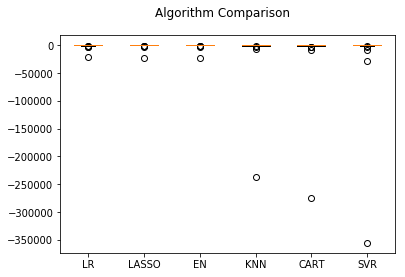

In [50]:
# Compare Algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [51]:
# Standardize the dataset
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR',LinearRegression())])))
pipelines.append(('ScaledLASSO', Pipeline([('Scaler', StandardScaler()),('LASSO',Lasso())])))
pipelines.append(('ScaledEN', Pipeline([('Scaler', StandardScaler()),('EN',ElasticNet())])))
# pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN',KNeighborsRegressor())])))
# pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART',DecisionTreeRegressor())])))
# pipelines.append(('ScaledSVR', Pipeline([('Scaler', StandardScaler()),('SVR',SVR())])))

In [52]:
results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, train_x, train_y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
#     print("RMSE: %.3f" % (math.sqrt(abs(cv_results.mean()))))

ScaledLR: -1317.825537 (4194.293147)
ScaledLASSO: -1341.605068 (4865.458969)


C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1111.371532439487, tolerance: 180.35578558558558
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 75467.87919972884, tolerance: 1649.228721081081
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 87947.72815335938, tolerance: 1721.7619769369371
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\skle

ScaledEN: -1752.642683 (6721.302186)


C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 90907.83949541417, tolerance: 1729.4252801080108
  positive)


In [53]:
results

[array([-2.14753051e+04, -3.06146789e+03, -2.73499747e+03, -1.41283017e+03,
        -3.40197314e+02, -6.77166493e+02, -4.55811029e+02, -4.00563597e+02,
        -1.59475185e+02, -9.02650776e+01, -9.96810985e+01, -8.78547365e+01,
        -6.22785552e+01, -4.60896736e+01, -3.69820912e+01, -1.47148395e+03,
        -5.58569349e+01, -3.35684987e+01, -2.85202348e+01, -2.43346190e+01,
        -7.52739706e+01, -4.06011632e+01, -2.97484607e+01, -3.00860568e+01,
        -1.51990137e+01]),
 array([-2.49947304e+04, -2.43871963e+03, -1.05097628e+03, -1.09690217e+03,
        -3.74305343e+02, -3.39940863e+02, -2.92576713e+02, -4.23944421e+02,
        -1.15166206e+02, -8.51677237e+01, -5.75007725e+01, -3.97524104e+01,
        -2.77719170e+01, -6.18365746e+01, -2.60448211e+01, -1.80088854e+03,
        -3.48421846e+01, -2.42233163e+01, -1.82320837e+01, -1.58517944e+01,
        -1.57558778e+02, -2.36128609e+01, -1.26180670e+01, -1.94598486e+01,
        -7.50297824e+00]),
 array([-3.45347345e+04, -2.503849

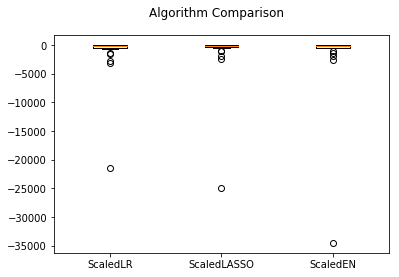

In [55]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

### Run LR

In [56]:
# Standard Scalar
from sklearn.preprocessing import StandardScaler
sc_data = StandardScaler()
train_x_std = sc_data.fit_transform(train_x)

In [57]:
import math
kfold = KFold(n_splits=10, random_state=7)
model = LinearRegression()
results = cross_val_score(model, train_x, train_y, cv=kfold, scoring='neg_mean_squared_error')
print("Negative MSE: %.3f (%.3f)" % (results.mean(), results.std()))
print("RMSE: %.3f" % (math.sqrt(abs(results.mean()))))

Negative MSE: -1699.376 (4086.268)
RMSE: 41.223


### Run Lasso

In [58]:
# Standard Scalar
from sklearn.preprocessing import StandardScaler
sc_data = StandardScaler()
train_x_std = sc_data.fit_transform(train_x)

In [59]:
from sklearn.linear_model import Lasso
lasso_model=Lasso()
lasso_model.fit(train_x_std,train_y)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [60]:
coef = pd.Series(lasso_model.coef_, index = train_x.columns)
print("Lasso model picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso model picked 16 variables and eliminated the other 155 variables


In [61]:
imp_coef = pd.concat([coef.sort_values(ascending=False).head(11),
                     coef.sort_values(ascending=False).tail(6)])
imp_coef

GRADDEG_CY    71.849506
HINC15_CY     34.468177
POPDENS_CY     9.817559
UNEMP_CY       9.095943
NHSPBLK_CY     7.971300
GQPOP_CY       5.595767
HISPOTH_CY     2.534232
HINC0_CY       2.414337
WIDOWED_CY     0.000000
GENX_CY        0.000000
HHPOP_CY       0.000000
NHSPMLT_CY    -1.442655
HISPASN_CY    -1.763912
MEDHINC_CY    -1.977512
PIFBASE_CY    -3.446499
NHSPOTH_CY    -4.672316
HISPBLK_CY    -8.110337
dtype: float64

Text(0.5, 1.0, 'Coefficients in the Lasso Model')

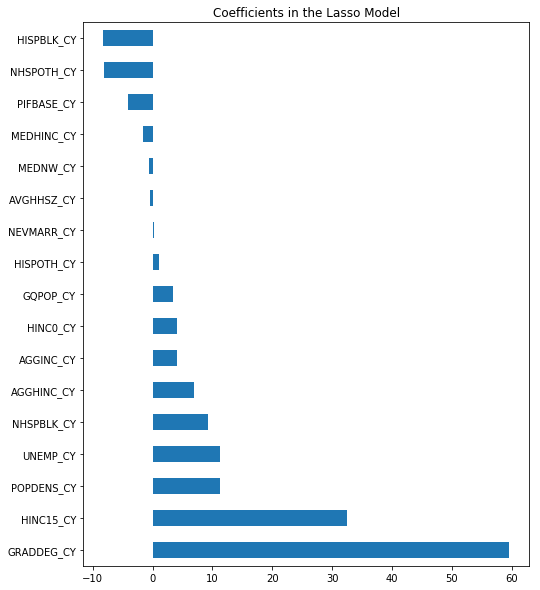

In [487]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

From the analysis above, we can see that factors that are predictive of higher provider count are:
- GRADDEG_CY (2018 Education: Graduate/Professional Degree (Esri))
- HINC15_CY (Household Income $15000 - $24999 (Esri))
- POPDENS_CY (2018 Population Density (Pop per Square Mile) (Esri))
- UNEMP_CY (2018 Unemployed Population Age 16+ (Esri))
- NHSPBLK_CY (2018 Black/African American Non-Hispanic Population (Esri))
- AGGINC_CY (2018 Aggregate Income (Esri))
- AGGHINC_CY (2018 Aggregate Household Income (Esri))
- HINC0_CY (Household Income less than $15000 (Esri))
- GQPOP_CY (2018 Group Quarters Population (Esri))
- HISPOTH_CY (2018 Hispanic Other Race Population (Esri))

Factors that negatively influence provider count are:
- HISPBLK_CY (2018 Hispanic Black/African American Population (Esri))
- NHSPOTH_CY (2018 Other Race Non-Hispanic Population (Esri))
- PIFBASE_CY (2018 Pacific Islander Female Population by Age Base (Esri))

### Add new columns - Provider Density

In [63]:
add_columns_df = test_newcounty_df.copy()

In [64]:
add_columns_df['WhitePop_Density'] = add_columns_df['WHITE_CY']/add_columns_df['TOTPOP_CY']
add_columns_df['BlackPop_Density'] = add_columns_df['BLACK_CY']/add_columns_df['TOTPOP_CY']
add_columns_df['WhitePop_Density'] = add_columns_df['WHITE_CY']/add_columns_df['TOTPOP_CY']
add_columns_df['AmeIndPop_Density'] = add_columns_df['AMERIND_CY']/add_columns_df['TOTPOP_CY']
add_columns_df['AsianPop_Density'] = add_columns_df['ASIAN_CY']/add_columns_df['TOTPOP_CY']
add_columns_df['PacificPop_Density'] = add_columns_df['PACIFIC_CY']/add_columns_df['TOTPOP_CY']
add_columns_df['OtherPop_Density'] = add_columns_df['OTHRACE_CY']/add_columns_df['TOTPOP_CY']
add_columns_df['HispanicPop_Density'] = add_columns_df['HISPPOP_CY']/add_columns_df['TOTPOP_CY']
add_columns_df['Provider_Density'] = add_columns_df['Provider_Count']/add_columns_df['TOTPOP_CY']

In [65]:
# Check Datatypes of different columns
g = add_columns_df.columns.to_series().groupby(add_columns_df.dtypes).groups
g

{dtype('int64'): Index(['Provider_Count'], dtype='object'),
 dtype('float64'): Index(['AAGEBASECY', 'AGGDI_CY', 'AGGHINC_CY', 'AGGINC_CY', 'AGGNW_CY',
        'AIFBASE_CY', 'AIMBASE_CY', 'AMERIND_CY', 'AREA', 'ASIAN_CY',
        ...
        'WHTMBASECY', 'WIDOWED_CY', 'WhitePop_Density', 'BlackPop_Density',
        'AmeIndPop_Density', 'AsianPop_Density', 'PacificPop_Density',
        'OtherPop_Density', 'HispanicPop_Density', 'Provider_Density'],
       dtype='object', length=179),
 dtype('O'): Index(['RegionAbbr', 'Subregion'], dtype='object')}

In [66]:
add_columns_df.head()

,RegionAbbr,Subregion,Provider_Count,AAGEBASECY,AGGDI_CY,AGGHINC_CY,AGGINC_CY,AGGNW_CY,AIFBASE_CY,AIMBASE_CY,AMERIND_CY,AREA,ASIAN_CY,ASNFBASECY,ASNMBASECY,ASSCDEG_CY,AVGDI_CY,AVGFMSZ_CY,AVGHHSZ_CY,AVGHINC_CY,AVGNW_CY,AVGVAL_CY,BABYBOOMCY,BACHDEG_CY,BAGEBASECY,BLACK_CY,BLKFBASECY,BLKMBASECY,CIVLBFR_CY,EDUCBASECY,EMP_CY,FAMHH_CY,FAMPOP_CY,FEM0_CY,FEM15_CY,FEM18UP_CY,FEM20_CY,FEM21UP_CY,FEM25_CY,FEM30_CY,FEM35_CY,FEM40_CY,FEM45_CY,FEM50_CY,FEM55_CY,FEM5_CY,FEM60_CY,FEM65_CY,FEM70_CY,FEM75_CY,FEM80_CY,FEM85_CY,FEMALES_CY,GED_CY,GENALPHACY,GENBASE_CY,GENX_CY,GENZ_CY,GQPOP_CY,GRADDEG_CY,HAGEBASECY,HHPOP_CY,HINC0_CY,HINC150_CY,HINC15_CY,HINC25_CY,HINC35_CY,HINC50_CY,HINC75_CY,HINCBASECY,HISPAI_CY,HISPASN_CY,HISPBLK_CY,HISPMLT_CY,HISPOTH_CY,HISPPI_CY,HISPPOP_CY,HISPWHT_CY,HSGRAD_CY,HSPFBASECY,HSPMBASECY,IAGEBASECY,LANDAREA,MAL18UP_CY,MAL21UP_CY,MALE0_CY,MALE15_CY,MALE20_CY,MALE25_CY,MALE30_CY,MALE35_CY,MALE40_CY,MALE45_CY,MALE50_CY,MALE55_CY,MALE5_CY,MALE60_CY,MALE65_CY,MALE70_CY,MALE75_CY,MALE80_CY,MALE85_CY,MALES_CY,MARBASE_CY,MARRIED_CY,MEDAGE_CY,MEDDI_CY,MEDFAGE_CY,MEDHHR_CY,MEDHINC_CY,MEDMAGE_CY,MEDNW_CY,MEDVAL_CY,MILLENN_CY,MINORITYCY,MLTFBASECY,MLTMBASECY,NEVMARR_CY,NHSPAI_CY,NHSPASN_CY,NHSPBLK_CY,NHSPMLT_CY,NHSPOTH_CY,NHSPPI_CY,NHSPWHT_CY,NOHS_CY,NONHISP_CY,OAGEBASECY,OLDRGENSCY,OTHFBASECY,OTHMBASECY,OTHRACE_CY,OWNER_CY,PACIFIC_CY,PAGEBASECY,PCI_CY,PIFBASE_CY,PIMBASE_CY,POP0_CY,POP15_CY,POP18UP_CY,POP20_CY,POP21UP_CY,POP25_CY,POP30_CY,POP35_CY,POP40_CY,POP45_CY,POP50_CY,POP55_CY,POP5_CY,POP60_CY,POP65_CY,POP70_CY,POP75_CY,POP80_CY,POP85_CY,POPDENS_CY,RACE2UP_CY,RACEBASECY,RENTER_CY,SMCOLL_CY,SOMEHS_CY,TOTHH_CY,TOTHU_CY,TOTPOP_CY,UNEMPRT_CY,UNEMP_CY,VACANT_CY,WAGEBASECY,WHITE_CY,WHTFBASECY,WHTMBASECY,WIDOWED_CY,WhitePop_Density,BlackPop_Density,AmeIndPop_Density,AsianPop_Density,PacificPop_Density,OtherPop_Density,HispanicPop_Density,Provider_Density
0,CA,Los Angeles County,2094,1517296.0,2.359152e+11,3.196410e+11,3.247511e+11,2.224411e+12,35957.0,37602.0,73559.0,4085.699440,1517296.0,805865.0,711431.0,469649.0,70013.0,3.63,3.00,94861.0,660145.0,710686.0,1987624.0,1445895.0,850350.0,850350.0,450243.0,400107.0,5232399.0,6899087.0,4995839.0,2281483.0,8292844.0,312953.0,331081.0,4077284.0,384255.0,3858162.0,421330.0,392960.0,359612.0,328513.0,335961.0,332084.0,327978.0,310887.0,291733.0,246493.0,183490.0,131256.0,90178.0,110499.0,5208957.0,120351.0,255399.0,10288937.0,2130083.0,2353920.0,176419.0,782758.0,5043293.0,10112518.0,371190.0,243110.0,310104.0,280437.0,390334.0,554983.0,394431.0,3369582.0,54769.0,22824.0,45013.0,261906.0,2280356.0,3826.0,5043293.0,2374599.0,1288396.0,2522627.0,2520666.0,73559.0,4057.8835,3890494.0,3663128.0,326230.0,351424.0,396276.0,433863.0,402148.0,368194.0,325765.0,331204.0,323486.0,307396.0,325231.0,261725.0,209710.0,149559.0,102402.0,65741.0,65807.0,5079980.0,8362123.0,3752436.0,35.7,52454.0,36.9,50.6,62751.0,34.6,60024.0,569360.0,2875966.0,7644196.0,251940.0,244185.0,3521307.0,18790.0,1494472.0,805337.0,234219.0,24674.0,23411.0,2644741.0,878838.0,5245644.0,2305030.0,685945.0,1141774.0,1163256.0,2305030.0,1538585.0,27237.0,27237.0,31563.0,13746.0,13491.0,639183.0,682505.0,7967778.0,780531.0,7521290.0,855193.0,795108.0,727806.0,654278.0,667165.0,655570.0,635374.0,636118.0,553458.0,456203.0,333049.0,233658.0,155919.0,176306.0,2535.5,496125.0,10288937.0,1831065.0,1300786.0,612414.0,3369650.0,3576478.0,10288937.0,4.5,236560.0,206828.0,5019340.0,5019340.0,2509432.0,2509908.0,413837.0,0.487839,0.082647,0.007149,0.147469,0.002647,0.224030,0.490167,0.000204
1,IL,Cook County,1586,395712.0,1.284204e+11,1.771502e+11,1.797564e+11,1.326345e+12,10418.0,10695.0,21113.0,953.145682,395712.0,206041.0,189671.0,237028.0,63978.0,3.36,2.58,88254.0,660769.0,335311.0,1076607.0,830433.0,1233716.0,1233716.0,674544.0,559172.0,2791109.0,3607345.0,2599303.0,1216270.0,4087547.0,158205.0,161652.0,2144742.0,185272.0,2040962.0,217698.0,207243.0,188312.0,166222.0,164629.0,166570.0,174115.0,159117.0,162326.0,139839.0,104629.0,75554.

#### Define Response and Predictor Variables

In [79]:
# Create prdictor and response variables
train_x = add_columns_df.iloc[:,3:-1]
train_y = add_columns_df.iloc[:,-1]
train_x.head()

,AAGEBASECY,AGGDI_CY,AGGHINC_CY,AGGINC_CY,AGGNW_CY,AIFBASE_CY,AIMBASE_CY,AMERIND_CY,AREA,ASIAN_CY,ASNFBASECY,ASNMBASECY,ASSCDEG_CY,AVGDI_CY,AVGFMSZ_CY,AVGHHSZ_CY,AVGHINC_CY,AVGNW_CY,AVGVAL_CY,BABYBOOMCY,BACHDEG_CY,BAGEBASECY,BLACK_CY,BLKFBASECY,BLKMBASECY,CIVLBFR_CY,EDUCBASECY,EMP_CY,FAMHH_CY,FAMPOP_CY,FEM0_CY,FEM15_CY,FEM18UP_CY,FEM20_CY,FEM21UP_CY,FEM25_CY,FEM30_CY,FEM35_CY,FEM40_CY,FEM45_CY,FEM50_CY,FEM55_CY,FEM5_CY,FEM60_CY,FEM65_CY,FEM70_CY,FEM75_CY,FEM80_CY,FEM85_CY,FEMALES_CY,GED_CY,GENALPHACY,GENBASE_CY,GENX_CY,GENZ_CY,GQPOP_CY,GRADDEG_CY,HAGEBASECY,HHPOP_CY,HINC0_CY,HINC150_CY,HINC15_CY,HINC25_CY,HINC35_CY,HINC50_CY,HINC75_CY,HINCBASECY,HISPAI_CY,HISPASN_CY,HISPBLK_CY,HISPMLT_CY,HISPOTH_CY,HISPPI_CY,HISPPOP_CY,HISPWHT_CY,HSGRAD_CY,HSPFBASECY,HSPMBASECY,IAGEBASECY,LANDAREA,MAL18UP_CY,MAL21UP_CY,MALE0_CY,MALE15_CY,MALE20_CY,MALE25_CY,MALE30_CY,MALE35_CY,MALE40_CY,MALE45_CY,MALE50_CY,MALE55_CY,MALE5_CY,MALE60_CY,MALE65_CY,MALE70_CY,MALE75_CY,MALE80_CY,MALE85_CY,MALES_CY,MARBASE_CY,MARRIED_CY,MEDAGE_CY,MEDDI_CY,MEDFAGE_CY,MEDHHR_CY,MEDHINC_CY,MEDMAGE_CY,MEDNW_CY,MEDVAL_CY,MILLENN_CY,MINORITYCY,MLTFBASECY,MLTMBASECY,NEVMARR_CY,NHSPAI_CY,NHSPASN_CY,NHSPBLK_CY,NHSPMLT_CY,NHSPOTH_CY,NHSPPI_CY,NHSPWHT_CY,NOHS_CY,NONHISP_CY,OAGEBASECY,OLDRGENSCY,OTHFBASECY,OTHMBASECY,OTHRACE_CY,OWNER_CY,PACIFIC_CY,PAGEBASECY,PCI_CY,PIFBASE_CY,PIMBASE_CY,POP0_CY,POP15_CY,POP18UP_CY,POP20_CY,POP21UP_CY,POP25_CY,POP30_CY,POP35_CY,POP40_CY,POP45_CY,POP50_CY,POP55_CY,POP5_CY,POP60_CY,POP65_CY,POP70_CY,POP75_CY,POP80_CY,POP85_CY,POPDENS_CY,RACE2UP_CY,RACEBASECY,RENTER_CY,SMCOLL_CY,SOMEHS_CY,TOTHH_CY,TOTHU_CY,TOTPOP_CY,UNEMPRT_CY,UNEMP_CY,VACANT_CY,WAGEBASECY,WHITE_CY,WHTFBASECY,WHTMBASECY,WIDOWED_CY,WhitePop_Density,BlackPop_Density,AmeIndPop_Density,AsianPop_Density,PacificPop_Density,OtherPop_Density,HispanicPop_Density
0,1517296.0,2.359152e+11,3.196410e+11,3.247511e+11,2.224411e+12,35957.0,37602.0,73559.0,4085.699440,1517296.0,805865.0,711431.0,469649.0,70013.0,3.63,3.00,94861.0,660145.0,710686.0,1987624.0,1445895.0,850350.0,850350.0,450243.0,400107.0,5232399.0,6899087.0,4995839.0,2281483.0,8292844.0,312953.0,331081.0,4077284.0,384255.0,3858162.0,421330.0,392960.0,359612.0,328513.0,335961.0,332084.0,327978.0,310887.0,291733.0,246493.0,183490.0,131256.0,90178.0,110499.0,5208957.0,120351.0,255399.0,10288937.0,2130083.0,2353920.0,176419.0,782758.0,5043293.0,10112518.0,371190.0,243110.0,310104.0,280437.0,390334.0,554983.0,394431.0,3369582.0,54769.0,22824.0,45013.0,261906.0,2280356.0,3826.0,5043293.0,2374599.0,1288396.0,2522627.0,2520666.0,73559.0,4057.8835,3890494.0,3663128.0,326230.0,351424.0,396276.0,433863.0,402148.0,368194.0,325765.0,331204.0,323486.0,307396.0,325231.0,261725.0,209710.0,149559.0,102402.0,65741.0,65807.0,5079980.0,8362123.0,3752436.0,35.7,52454.0,36.9,50.6,62751.0,34.6,60024.0,569360.0,2875966.0,7644196.0,251940.0,244185.0,3521307.0,18790.0,1494472.0,805337.0,234219.0,24674.0,23411.0,2644741.0,878838.0,5245644.0,2305030.0,685945.0,1141774.0,1163256.0,2305030.0,1538585.0,27237.0,27237.0,31563.0,13746.0,13491.0,639183.0,682505.0,7967778.0,780531.0,7521290.0,855193.0,795108.0,727806.0,654278.0,667165.0,655570.0,635374.0,636118.0,553458.0,456203.0,333049.0,233658.0,155919.0,176306.0,2535.5,496125.0,10288937.0,1831065.0,1300786.0,612414.0,3369650.0,3576478.0,10288937.0,4.5,236560.0,206828.0,5019340.0,5019340.0,2509432.0,2509908.0,413837.0,0.487839,0.082647,0.007149,0.147469,0.002647,0.224030,0.490167
1,395712.0,1.284204e+11,1.771502e+11,1.797564e+11,1.326345e+12,10418.0,10695.0,21113.0,953.145682,395712.0,206041.0,189671.0,237028.0,63978.0,3.36,2.58,88254.0,660769.0,335311.0,1076607.0,830433.0,1233716.0,1233716.0,674544.0,559172.0,2791109.0,3607345.0,2599303.0,1216270.0,4087547.0,158205.0,161652.0,2144742.0,185272.0,2040962.0,217698.0,207243.0,188312.0,166222.0,164629.0,166570.0,174115.0,159117.0,162326.0,139839.0,104629.0,75554.0,54048.0,70522.0,2717277.0,95959.0,129327.0,5274129.0,1058747.0,1171989.0,90942.0,552050.0,1374256.0,5183187

In [80]:
train_x.shape

(1157, 178)

In [81]:
train_y.head()

0    0.000204
1    0.000301
2    0.000684
3    0.000237
4    0.000192
Name: Provider_Density, dtype: float64

#### Identify Best Model

In [82]:
# Test options and evaluation metric
num_folds = 10
seed = 7
scoring ='neg_mean_squared_error'

In [83]:
# Spot-Check Algorithms
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))

In [84]:
# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, train_x, train_y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: -0.000000 (0.000000)


C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.315384803230892e-06, tolerance: 1.47446680422909e-09
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.173040652991125e-06, tolerance: 1.1016880992866113e-09
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.995571428473911e-06, tolerance: 1.6678652527430239e-09
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis

LASSO: -0.000000 (0.000000)


C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.92841577466613e-06, tolerance: 1.6678652527430239e-09
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.953424049941943e-06, tolerance: 1.6735099171517605e-09
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.881782928385075e-06, tolerance: 1.6639492179839088e-09
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgi

EN: -0.000000 (0.000000)
KNN: -0.000000 (0.000000)
CART: -0.000000 (0.000000)
SVR: -0.000001 (0.000000)


C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  

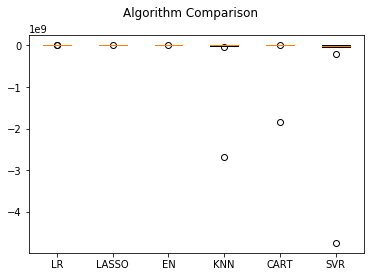

In [73]:
# Compare Algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [85]:
# Standardize the dataset
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR',LinearRegression())])))
pipelines.append(('ScaledLASSO', Pipeline([('Scaler', StandardScaler()),('LASSO',Lasso())])))
pipelines.append(('ScaledEN', Pipeline([('Scaler', StandardScaler()),('EN',ElasticNet())])))
# pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN',KNeighborsRegressor())])))
# pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART',DecisionTreeRegressor())])))
# pipelines.append(('ScaledSVR', Pipeline([('Scaler', StandardScaler()),('SVR',SVR())])))

In [86]:
results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, train_x, train_y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
#     print("RMSE: %.3f" % (math.sqrt(abs(cv_results.mean()))))

ScaledLR: -0.000000 (0.000000)
ScaledLASSO: -0.000000 (0.000000)
ScaledEN: -0.000000 (0.000000)


In [76]:
results

[array([-1.76991550e-20, -1.78346558e-21, -4.76548734e-22, -4.91459378e-22,
        -1.10718838e-21, -8.61251897e-22, -1.33795751e-21, -6.23579096e-22,
        -2.46384737e-22, -2.25784343e-22]),
 array([ -15347.825701  , -189235.12887074,  -73880.57488155,
         -24043.97653174,  -14866.25757397,  -12340.95647885,
         -39853.82095786,   -7863.94556402,   -5181.98778434,
          -6383.41712349]),
 array([-16733217.53135702,  -3442336.61974144,  -1152295.35352573,
          -332213.38812121,   -248278.21486488,   -187961.83823544,
          -609863.20757641,   -220717.33140251,   -279056.5239558 ,
          -620581.75701461])]

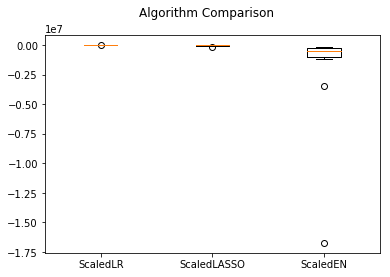

In [77]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

## Run Elastic Net

### Using Densities

In [204]:
# Create prdictor and response variables
train_x = test_newstate_df.iloc[:,:20]
train_y = test_newstate_df.iloc[:,-1]
train_x.head()

,Provider_Count,AAGEBASECY,AGGDI_CY,AGGHINC_CY,AGGINC_CY,AGGNW_CY,AIFBASE_CY,AIMBASE_CY,AMERIND_CY,AREA,ASIAN_CY,ASNFBASECY,ASNMBASECY,ASSCDEG_CY,AVGDI_CY,AVGFMSZ_CY,AVGHHSZ_CY,AVGHINC_CY,AVGNW_CY,AVGVAL_CY
0,7353.0,5808539,984770070408,1341852609490,1363545956974,10953288740347,186300,188412,374712,158042.920912,5808539,3057816,2750723,2056384,73844,3.50,2.92,100620,821339,637422
1,5115.0,1428081,663797428676,846781778790,860166554925,6544101733836,99642,101050,200692,264622.431161,1428081,736438,691643,1352089,65007,3.36,2.78,82927,640876,234140
2,5005.0,1774868,494056143933,721252426439,733561461654,5780147040071,57206,55978,113184,48359.759399,1774868,920657,854211,1234468,65662,3.27,2.59,95857,768205,451725
3,4133.0,585936,487005072197,613723856820,624450149363,6548612367402,40665,42463,83128,56491.338012,585936,316402,269534,1468305,59737,3.03,2.51,75281,803267,282862
4,3210.0,462360,315983343213,411902114464,418518490501,4125980999869,16036,16102,32138,45285.896438,462360,240313,222047,749637,61749,3.02,2.46,80493,806294,236846


In [422]:
# Standard Scalar
from sklearn.preprocessing import StandardScaler
sc_data = StandardScaler()
train_x_std = sc_data.fit_transform(train_x)
# Transform predictors
# from sklearn.preprocessing import PowerTransformer
# pt_data = PowerTransformer(method='box-cox')
# train_x_pt = pt_data.fit_transform(train_x)

# from scipy.stats import boxcox
# train_x_pt = boxcox(train_x)

In [423]:
# train_x_pt
train_x_std

array([[22.34795477, 18.05516815, 17.965054  , ..., 16.44519452,
        16.80905623, 18.62762542],
       [ 5.6822489 ,  9.64669999,  9.78298609, ...,  9.31051713,
         9.20807555, 11.08252361],
       [ 2.96499875,  4.82089499,  5.87652831, ...,  2.74204776,
         2.58167517,  2.70928177],
       ...,
       [-0.19646359, -0.37685625, -0.37043563, ..., -0.45093924,
        -0.44262892, -0.40747586],
       [-0.19531945, -0.36966815, -0.36346963, ..., -0.41996093,
        -0.41624254, -0.37088673],
       [-0.1937741 , -0.34420822, -0.33565532, ..., -0.3871941 ,
        -0.38137309, -0.34955075]])

#### Tune and Run

Regularization strength is regulated by alpha (similar to lambda in the equation). l1_ratio allows us to vary L1 vs L2 ratio. When the l1_ratio is set to 0 it is the same as ridge regression. When l1_ratio is set to 1 it is lasso.

In [428]:
# Tune hyperparameters for Elastic Net regression

from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
parametersGrid = {"alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                  "l1_ratio": [.1, .5, .7, .9, .95, .99, 1]}

eNet = ElasticNet(random_state=3, max_iter=1000)
grid = GridSearchCV(eNet, parametersGrid, scoring='neg_mean_squared_error', cv=10)
grid.fit(train_x_std, train_y)
best_idx = grid.best_index_

C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41678.51954203416, tolerance: 45.19170444874274
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 161895.03584090917, tolerance: 1693.9877741779496
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 195211.52846741414, tolerance: 1701.5631427466149
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sk

C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 210115.57965929367, tolerance: 1680.5346720772945
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38991.51918803835, tolerance: 45.19170444874274
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 158531.91208379835, tolerance: 1693.9877741779496
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sk

C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 208113.67372772162, tolerance: 1683.3855794970991
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 209042.25466932406, tolerance: 1681.6908986460348
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 208928.88932987335, tolerance: 1680.5346720772945
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\

C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 218277.23055833086, tolerance: 1690.6666055125722
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 218825.74330476363, tolerance: 1687.4250113152802
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 203576.53017394606, tolerance: 1685.1196220502902
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\

C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 158938.75369887473, tolerance: 1693.9877741779496
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 191175.55660511294, tolerance: 1701.5631427466149
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 204883.72319995982, tolerance: 1695.9653531914894
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\

C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 206293.98533976538, tolerance: 1680.5346720772945
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 46630.003611657834, tolerance: 45.19170444874274
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 230822.3979823824, tolerance: 1693.9877741779496
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sk

C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 186454.97338264264, tolerance: 1685.1196220502902
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 190694.33298899583, tolerance: 1683.3855794970991
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 190978.97933677194, tolerance: 1681.6908986460348
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\

C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 168073.2711810842, tolerance: 1690.6666055125722
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 167846.5435118922, tolerance: 1687.4250113152802
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 167389.28331844986, tolerance: 1685.1196220502902
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sk

C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 226510.15314598358, tolerance: 1695.9653531914894
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 222665.48881026456, tolerance: 1690.6666055125722
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 220752.91201737954, tolerance: 1687.4250113152802
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\

C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 59499.38913881907, tolerance: 1690.6666055125722
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 59579.80462290539, tolerance: 1687.4250113152802
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56942.63155557861, tolerance: 1685.1196220502902
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\skl

C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 393939.6402163658, tolerance: 1690.6666055125722
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 386639.0146009138, tolerance: 1687.4250113152802
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 334992.08431829535, tolerance: 1685.1196220502902
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sk

C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5460.929937050096, tolerance: 1685.1196220502902
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6913.898069663555, tolerance: 1683.3855794970991
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7034.813022656832, tolerance: 1681.6908986460348
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\skl

C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3085.3780808569863, tolerance: 1681.6908986460348
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3110.7923936082516, tolerance: 1680.5346720772945
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\mohi9282\AppData\Local\Continuum\anaco

In [429]:
print('Best Elastic Net parameters: ' + str(e_gs.best_params_))
print('Best EL cross-validation score: ' + str(e_gs.best_score_))

Best Elastic Net parameters: {'alpha': 0.1, 'l1_ratio': 1}
Best EL cross-validation score: -4144.818911275162


#### Run using parameters from tuning

In [431]:
elastic=ElasticNet(alpha=0.1,l1_ratio=1)
elastic.fit(train_x_std,train_y)

C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35780.44715979218, tolerance: 1704.0840955613576
  positive)


ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True, l1_ratio=1,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

#### Get Variable Coefficients

In [432]:
coef = pd.Series(elastic.coef_, index = train_x.columns)
print("Elastic Net picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Elastic Net picked 48 variables and eliminated the other 123 variables


In [433]:
coef_dict_baseline = {}
for coef, feat in zip(elastic.coef_,train_x.columns):
    coef_dict_baseline[feat] = coef
coef_dict_baseline

{'AAGEBASECY': 0.0,
 'AGGDI_CY': 47.42115457157865,
 'AGGHINC_CY': 87.15589867412909,
 'AGGINC_CY': 3.412823220878211,
 'AGGNW_CY': 0.0,
 'AIFBASE_CY': 0.0,
 'AIMBASE_CY': 0.0,
 'AMERIND_CY': 0.0,
 'AREA': 0.0,
 'ASIAN_CY': 0.0,
 'ASNFBASECY': 0.0,
 'ASNMBASECY': 0.0,
 'ASSCDEG_CY': -2.2187711479879986,
 'AVGDI_CY': 0.0,
 'AVGFMSZ_CY': 1.8384091345091094,
 'AVGHHSZ_CY': 0.0,
 'AVGHINC_CY': 0.0,
 'AVGNW_CY': 1.1031864351227876,
 'AVGVAL_CY': 0.0,
 'BABYBOOMCY': -0.0,
 'BACHDEG_CY': 0.0,
 'BAGEBASECY': 0.0,
 'BLACK_CY': 0.0,
 'BLKFBASECY': 0.0,
 'BLKMBASECY': 0.0,
 'CIVLBFR_CY': -0.0,
 'EDUCBASECY': -0.0,
 'EMP_CY': -0.0,
 'FAMHH_CY': -0.0,
 'FAMPOP_CY': -0.0,
 'FEM0_CY': -13.003996879838455,
 'FEM15_CY': -0.0,
 'FEM18UP_CY': -0.0,
 'FEM20_CY': -6.4407237518483,
 'FEM21UP_CY': -0.0,
 'FEM25_CY': -0.0,
 'FEM30_CY': -0.0,
 'FEM35_CY': -0.0,
 'FEM40_CY': -0.0,
 'FEM45_CY': -0.0,
 'FEM50_CY': -0.0,
 'FEM55_CY': -0.0,
 'FEM5_CY': -0.0,
 'FEM60_CY': -0.0,
 'FEM65_CY': -0.0,
 'FEM70_CY': -0.092

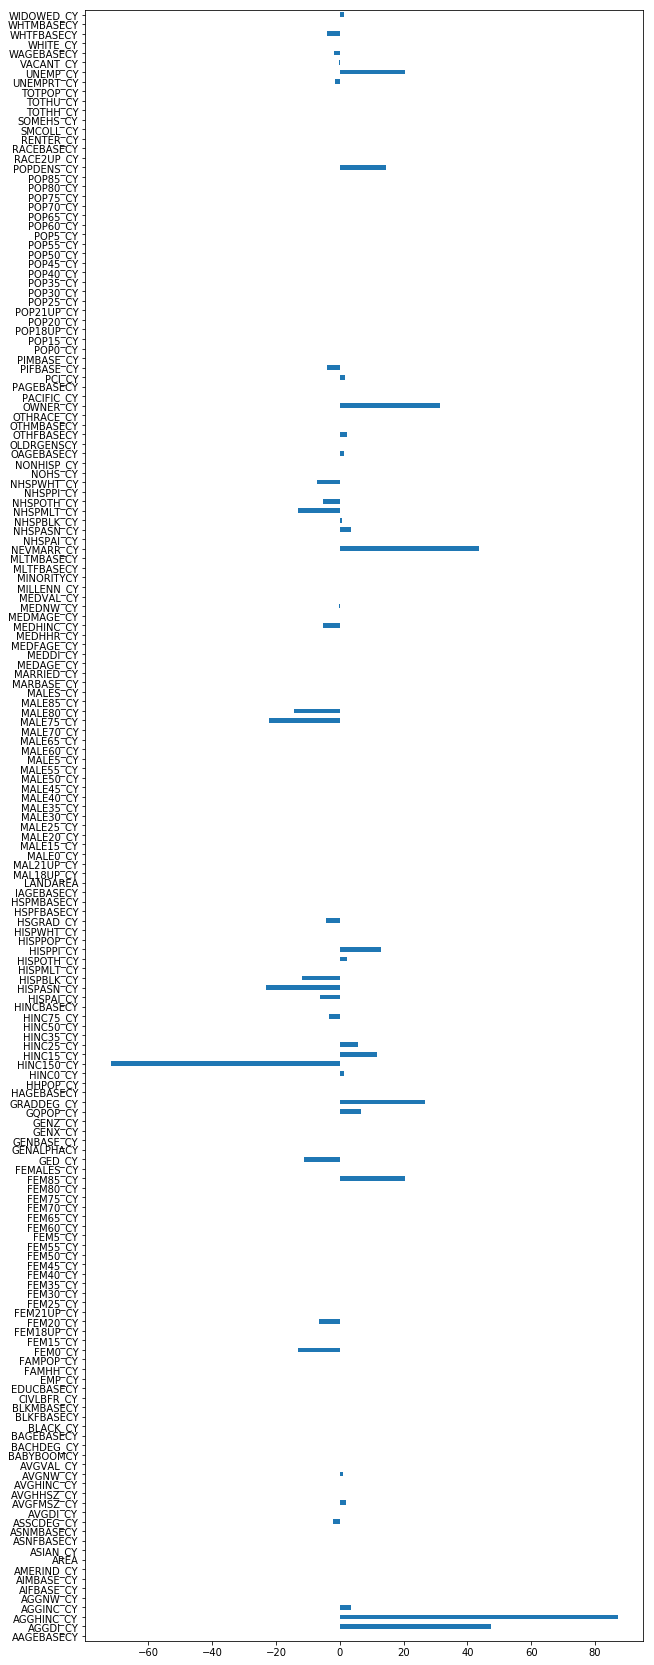

In [434]:
plt.figure(figsize=(10,30))
featureimp = pd.Series(elastic.coef_, index = train_x.columns)
featureimp.plot(kind='barh')
plt.show()

In [ ]:
# Using densities with box-cox
Best Elastic Net parameters: {'alpha': 0.1, 'l1_ratio': 0.1}
Best EL cross-validation score: -2.5487352278940628e-09

# Not using densities

### Not Using Densities

In [110]:
# Create copy of df to remove density columns
test_newstate_copy = test_newstate_df.iloc[:,:-8]
test_newstate_copy.head()

,Provider_Count,AAGEBASECY,AGGDI_CY,AGGHINC_CY,AGGINC_CY,AGGNW_CY,AIFBASE_CY,AIMBASE_CY,AMERIND_CY,AREA,ASIAN_CY,ASNFBASECY,ASNMBASECY,ASSCDEG_CY,AVGDI_CY,AVGFMSZ_CY,AVGHHSZ_CY,AVGHINC_CY,AVGNW_CY,AVGVAL_CY,BABYBOOMCY,BACHDEG_CY,BAGEBASECY,BLACK_CY,BLKFBASECY,BLKMBASECY,CIVLBFR_CY,EDUCBASECY,EMP_CY,FAMHH_CY,FAMPOP_CY,FEM0_CY,FEM15_CY,FEM18UP_CY,FEM20_CY,FEM21UP_CY,FEM25_CY,FEM30_CY,FEM35_CY,FEM40_CY,FEM45_CY,FEM50_CY,FEM55_CY,FEM5_CY,FEM60_CY,FEM65_CY,FEM70_CY,FEM75_CY,FEM80_CY,FEM85_CY,FEMALES_CY,GED_CY,GENALPHACY,GENBASE_CY,GENX_CY,GENZ_CY,GQPOP_CY,GRADDEG_CY,HAGEBASECY,HHPOP_CY,HINC0_CY,HINC150_CY,HINC15_CY,HINC25_CY,HINC35_CY,HINC50_CY,HINC75_CY,HINCBASECY,HISPAI_CY,HISPASN_CY,HISPBLK_CY,HISPMLT_CY,HISPOTH_CY,HISPPI_CY,HISPPOP_CY,HISPWHT_CY,HSGRAD_CY,HSPFBASECY,HSPMBASECY,IAGEBASECY,LANDAREA,MAL18UP_CY,MAL21UP_CY,MALE0_CY,MALE15_CY,MALE20_CY,MALE25_CY,MALE30_CY,MALE35_CY,MALE40_CY,MALE45_CY,MALE50_CY,MALE55_CY,MALE5_CY,MALE60_CY,MALE65_CY,MALE70_CY,MALE75_CY,MALE80_CY,MALE85_CY,MALES_CY,MARBASE_CY,MARRIED_CY,MEDAGE_CY,MEDDI_CY,MEDFAGE_CY,MEDHHR_CY,MEDHINC_CY,MEDMAGE_CY,MEDNW_CY,MEDVAL_CY,MILLENN_CY,MINORITYCY,MLTFBASECY,MLTMBASECY,NEVMARR_CY,NHSPAI_CY,NHSPASN_CY,NHSPBLK_CY,NHSPMLT_CY,NHSPOTH_CY,NHSPPI_CY,NHSPWHT_CY,NOHS_CY,NONHISP_CY,OAGEBASECY,OLDRGENSCY,OTHFBASECY,OTHMBASECY,OTHRACE_CY,OWNER_CY,PACIFIC_CY,PAGEBASECY,PCI_CY,PIFBASE_CY,PIMBASE_CY,POP0_CY,POP15_CY,POP18UP_CY,POP20_CY,POP21UP_CY,POP25_CY,POP30_CY,POP35_CY,POP40_CY,POP45_CY,POP50_CY,POP55_CY,POP5_CY,POP60_CY,POP65_CY,POP70_CY,POP75_CY,POP80_CY,POP85_CY,POPDENS_CY,RACE2UP_CY,RACEBASECY,RENTER_CY,SMCOLL_CY,SOMEHS_CY,TOTHH_CY,TOTHU_CY,TOTPOP_CY,UNEMPRT_CY,UNEMP_CY,VACANT_CY,WAGEBASECY,WHITE_CY,WHTFBASECY,WHTMBASECY,WIDOWED_CY
0,7353.0,5808539,984770070408,1341852609490,1363545956974,10953288740347,186300,188412,374712,158042.920912,5808539,3057816,2750723,2056384,73844,3.50,2.92,100620,821339,637422,8055682,5552919,2345048,2345048,1186331,1158717,19595308,26629106,18678853,9166028,32063051,1246195,1267704,15535129,1399534,14709444,1533458,1442776,1332317,1220853,1252603,1262625,1290328,1247274,1173091,1008278,746364,527232,362402,447803,20024285,621048,1008060,39806791,8011720,9289070,813593,3342632,15757962,38993198,1280615,1084396,1102410,1036596,1486913,2149782,1630222,13335897,214901,94837,149373,953706,7017528,17243,15757962,7310374,4804568,7811593,7946369,374712,155779.2198,15076422,14203971,1298461,1348980,1481021,1618901,1503701,1378564,1227529,1251002,1245261,1228175,1301504,1076510,891235,637267,427533,272897,270401,19782506,32126345,15627854,36.2,56020,37.3,51.5,69051,35.1,99297,505800,10636136,25228888,1076167,1053726,11926897,159811,5713702,2195675,1176187,84542,141009,14577903,2557052,24048829,7102070,2806123,3484353,3617717,7102070,7294468,158252,158252,34254,79878,78374,2544656,2616684,30611551,2880555,28913415,3152359,2946477,2710881,2448382,2503605,2507886,2518503,2548778,2249601,1899513,1383631,954765,635299,718204,255.5,2129893,39806791,6041636,5627462,2067041,13336104,14383561,39806791,4.7,916455,1047457,21888277,21888277,10953440,10934837,1601462
1,5115.0,1428081,663797428676,846781778790,860166554925,6544101733836,99642,101050,200692,264622.431161,1428081,736438,691643,1352089,65007,3.36,2.78,82927,640876,234140,5610338,3595450,3554094,3554094,1837649,1716445,13994294,18710254,13323060,7102474,23868426,1012163,958641,11007087,1023650,10392959,1088542,1028122,990111,912087,908014,888197,906409,1016393,815633,699159,508500,349890,230272,255883,14596063,796406,820030,28954616,5795902,7332348,603396,1902087,11500677,28351220,1099136,601595,972153,998707,1339610,1837748,1220161,10211181,108000,21467,126710,446880,3229534,4993,11500677,7563093,3900291,5712914,5787763,200692,261231.7115,10619025,9978508,1049926,1010959,1068334,1146033,1057803,1000356,900336,893942,864949,855845,1054854,749300,623922,440199,284583,169339,142828,14358553,22771838,11608584,34.8,48504,35.8,49.5,57286,33.8,89454,173734,7624216,16954978,459123,454026,7616564,92692,1406

In [170]:
# 
train_x_new = test_newstate_copy.iloc[:,1:]
# train_y_new = np.log(test_newstate_df.iloc[:,0].values+1)
train_y_new = test_newstate_df.iloc[:,0]

In [171]:
train_x_new.head()

,AAGEBASECY,AGGDI_CY,AGGHINC_CY,AGGINC_CY,AGGNW_CY,AIFBASE_CY,AIMBASE_CY,AMERIND_CY,AREA,ASIAN_CY,ASNFBASECY,ASNMBASECY,ASSCDEG_CY,AVGDI_CY,AVGFMSZ_CY,AVGHHSZ_CY,AVGHINC_CY,AVGNW_CY,AVGVAL_CY,BABYBOOMCY,BACHDEG_CY,BAGEBASECY,BLACK_CY,BLKFBASECY,BLKMBASECY,CIVLBFR_CY,EDUCBASECY,EMP_CY,FAMHH_CY,FAMPOP_CY,FEM0_CY,FEM15_CY,FEM18UP_CY,FEM20_CY,FEM21UP_CY,FEM25_CY,FEM30_CY,FEM35_CY,FEM40_CY,FEM45_CY,FEM50_CY,FEM55_CY,FEM5_CY,FEM60_CY,FEM65_CY,FEM70_CY,FEM75_CY,FEM80_CY,FEM85_CY,FEMALES_CY,GED_CY,GENALPHACY,GENBASE_CY,GENX_CY,GENZ_CY,GQPOP_CY,GRADDEG_CY,HAGEBASECY,HHPOP_CY,HINC0_CY,HINC150_CY,HINC15_CY,HINC25_CY,HINC35_CY,HINC50_CY,HINC75_CY,HINCBASECY,HISPAI_CY,HISPASN_CY,HISPBLK_CY,HISPMLT_CY,HISPOTH_CY,HISPPI_CY,HISPPOP_CY,HISPWHT_CY,HSGRAD_CY,HSPFBASECY,HSPMBASECY,IAGEBASECY,LANDAREA,MAL18UP_CY,MAL21UP_CY,MALE0_CY,MALE15_CY,MALE20_CY,MALE25_CY,MALE30_CY,MALE35_CY,MALE40_CY,MALE45_CY,MALE50_CY,MALE55_CY,MALE5_CY,MALE60_CY,MALE65_CY,MALE70_CY,MALE75_CY,MALE80_CY,MALE85_CY,MALES_CY,MARBASE_CY,MARRIED_CY,MEDAGE_CY,MEDDI_CY,MEDFAGE_CY,MEDHHR_CY,MEDHINC_CY,MEDMAGE_CY,MEDNW_CY,MEDVAL_CY,MILLENN_CY,MINORITYCY,MLTFBASECY,MLTMBASECY,NEVMARR_CY,NHSPAI_CY,NHSPASN_CY,NHSPBLK_CY,NHSPMLT_CY,NHSPOTH_CY,NHSPPI_CY,NHSPWHT_CY,NOHS_CY,NONHISP_CY,OAGEBASECY,OLDRGENSCY,OTHFBASECY,OTHMBASECY,OTHRACE_CY,OWNER_CY,PACIFIC_CY,PAGEBASECY,PCI_CY,PIFBASE_CY,PIMBASE_CY,POP0_CY,POP15_CY,POP18UP_CY,POP20_CY,POP21UP_CY,POP25_CY,POP30_CY,POP35_CY,POP40_CY,POP45_CY,POP50_CY,POP55_CY,POP5_CY,POP60_CY,POP65_CY,POP70_CY,POP75_CY,POP80_CY,POP85_CY,POPDENS_CY,RACE2UP_CY,RACEBASECY,RENTER_CY,SMCOLL_CY,SOMEHS_CY,TOTHH_CY,TOTHU_CY,TOTPOP_CY,UNEMPRT_CY,UNEMP_CY,VACANT_CY,WAGEBASECY,WHITE_CY,WHTFBASECY,WHTMBASECY,WIDOWED_CY
0,5808539,984770070408,1341852609490,1363545956974,10953288740347,186300,188412,374712,158042.920912,5808539,3057816,2750723,2056384,73844,3.50,2.92,100620,821339,637422,8055682,5552919,2345048,2345048,1186331,1158717,19595308,26629106,18678853,9166028,32063051,1246195,1267704,15535129,1399534,14709444,1533458,1442776,1332317,1220853,1252603,1262625,1290328,1247274,1173091,1008278,746364,527232,362402,447803,20024285,621048,1008060,39806791,8011720,9289070,813593,3342632,15757962,38993198,1280615,1084396,1102410,1036596,1486913,2149782,1630222,13335897,214901,94837,149373,953706,7017528,17243,15757962,7310374,4804568,7811593,7946369,374712,155779.2198,15076422,14203971,1298461,1348980,1481021,1618901,1503701,1378564,1227529,1251002,1245261,1228175,1301504,1076510,891235,637267,427533,272897,270401,19782506,32126345,15627854,36.2,56020,37.3,51.5,69051,35.1,99297,505800,10636136,25228888,1076167,1053726,11926897,159811,5713702,2195675,1176187,84542,141009,14577903,2557052,24048829,7102070,2806123,3484353,3617717,7102070,7294468,158252,158252,34254,79878,78374,2544656,2616684,30611551,2880555,28913415,3152359,2946477,2710881,2448382,2503605,2507886,2518503,2548778,2249601,1899513,1383631,954765,635299,718204,255.5,2129893,39806791,6041636,5627462,2067041,13336104,14383561,39806791,4.7,916455,1047457,21888277,21888277,10953440,10934837,1601462
1,1428081,663797428676,846781778790,860166554925,6544101733836,99642,101050,200692,264622.431161,1428081,736438,691643,1352089,65007,3.36,2.78,82927,640876,234140,5610338,3595450,3554094,3554094,1837649,1716445,13994294,18710254,13323060,7102474,23868426,1012163,958641,11007087,1023650,10392959,1088542,1028122,990111,912087,908014,888197,906409,1016393,815633,699159,508500,349890,230272,255883,14596063,796406,820030,28954616,5795902,7332348,603396,1902087,11500677,28351220,1099136,601595,972153,998707,1339610,1837748,1220161,10211181,108000,21467,126710,446880,3229534,4993,11500677,7563093,3900291,5712914,5787763,200692,261231.7115,10619025,9978508,1049926,1010959,1068334,1146033,1057803,1000356,900336,893942,864949,855845,1054854,749300,623922,440199,284583,169339,142828,14358553,22771838,11608584,34.8,48504,35.8,49.5,57286,33.8,89454,173734,7624216,16954978,459123,454026,7616564,92692,1406614,3427384,466269,37515,2382

In [172]:
# # Transform predictors
# from sklearn.preprocessing import PowerTransformer
# pt_data = PowerTransformer(method='box-cox')
# train_x_pt = pt_data.fit_transform(train_x_new)

# Standard Scalar
from sklearn.preprocessing import StandardScaler
sc_data = StandardScaler()
train_x_std = sc_data.fit_transform(train_x_new)

In [173]:
parametersGrid = {"alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                  "l1_ratio": [.1, .5, .7, .9, .95, .99, 1]}

eNet = ElasticNet(random_state=3, max_iter=1000)
grid = GridSearchCV(eNet, parametersGrid, scoring='neg_mean_squared_error', cv=10)
grid.fit(train_x_std, train_y_new)

C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20156.070166797137, tolerance: 2005.932311111111
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25580.82539699177, tolerance: 10274.911982608697
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36596.932696175005, tolerance: 10780.223436956523
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sk

C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27611.69697752278, tolerance: 10808.597982608695
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30505.919853909458, tolerance: 10738.399697826088
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28290.68652379256, tolerance: 10591.733297826087
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sk

C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26451.98568048466, tolerance: 10780.223436956523
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26402.902625341812, tolerance: 10808.597982608695
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29499.46931559191, tolerance: 10738.399697826088
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sk

C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 53351.77292431351, tolerance: 10591.733297826087
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 50457.35871366033, tolerance: 10432.601671739134
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 60915.047082394005, tolerance: 10288.7006
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\li

C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35135.74182869109, tolerance: 10198.469210869565
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29543.79290940451, tolerance: 10062.415610869568
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7186.503147732061, tolerance: 2005.932311111111
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\skle

C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 78487.06611649539, tolerance: 10274.911982608697
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 127881.2715122926, tolerance: 10780.223436956523
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 136975.0982249205, tolerance: 10808.597982608695
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\skl

C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41965.66307585173, tolerance: 10808.597982608695
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 43414.320110149194, tolerance: 10738.399697826088
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42666.3000587859, tolerance: 10591.733297826087
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\skl

C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 369594.9601081552, tolerance: 10432.601671739134
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 342872.256096235, tolerance: 10288.7006
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 371066.05115251674, tolerance: 10198.469210869565
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\lin

C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 172440.25613825218, tolerance: 10062.415610869568
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31015.572063338215, tolerance: 2005.932311111111
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 68407.39152420318, tolerance: 10274.911982608697
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sk

C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 725458.5199430198, tolerance: 10591.733297826087
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 725983.6848212457, tolerance: 10432.601671739134
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 669429.8122573944, tolerance: 10288.7006
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\lin

C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 102839.21529204986, tolerance: 10808.597982608695
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 114155.05398217516, tolerance: 10738.399697826088
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 123541.44240985933, tolerance: 10591.733297826087
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\

C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 40231.34455722105, tolerance: 10591.733297826087
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39890.750481483876, tolerance: 10432.601671739134
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41666.83008177369, tolerance: 10288.7006
  positive)
C:\Users\mohi9282\AppData\Local\Continuum\anaconda3\envs\arcgis\lib\site-packages\sklearn\li

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=1000, normalize=False,
                                  positive=False, precompute=False,
                                  random_state=3, selection='cyclic',
                                  tol=0.0001, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                         'l1_ratio': [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [174]:
print('Best Elastic Net parameters: ' + str(grid.best_params_))
print('Best EL cross-validation score: ' + str(grid.best_score_))

Best Elastic Net parameters: {'alpha': 1, 'l1_ratio': 0.5}
Best EL cross-validation score: -35089.43647606921


#### Run using parameters from tuning

In [166]:
elastic=ElasticNet(alpha=0.0001,l1_ratio=0.1)
elastic.fit(train_x_std,train_y)

ElasticNet(alpha=0.0001, copy_X=True, fit_intercept=True, l1_ratio=0.1,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

#### Get Variable Coefficients

In [168]:
coef = pd.Series(elastic.coef_, index = train_x.columns)
print("Elastic Net picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Elastic Net picked 6 variables and eliminated the other 173 variables


In [167]:
coef_dict_baseline = {}
for coef, feat in zip(elastic.coef_,train_x.columns):
    coef_dict_baseline[feat] = coef
coef_dict_baseline

{'Provider_Count': 0.0,
 'AAGEBASECY': -0.0,
 'AGGDI_CY': 0.0,
 'AGGHINC_CY': 0.0,
 'AGGINC_CY': 0.0,
 'AGGNW_CY': 0.0,
 'AIFBASE_CY': -0.0,
 'AIMBASE_CY': -0.0,
 'AMERIND_CY': -0.0,
 'AREA': -0.0,
 'ASIAN_CY': -0.0,
 'ASNFBASECY': -0.0,
 'ASNMBASECY': -0.0,
 'ASSCDEG_CY': 0.0,
 'AVGDI_CY': 0.0,
 'AVGFMSZ_CY': -0.0,
 'AVGHHSZ_CY': -0.0,
 'AVGHINC_CY': 0.0,
 'AVGNW_CY': 0.0,
 'AVGVAL_CY': 1.3363209295111027e-06,
 'BABYBOOMCY': 0.0,
 'BACHDEG_CY': 0.0,
 'BAGEBASECY': 0.0,
 'BLACK_CY': 0.0,
 'BLKFBASECY': 0.0,
 'BLKMBASECY': 0.0,
 'CIVLBFR_CY': 0.0,
 'EDUCBASECY': 0.0,
 'EMP_CY': 0.0,
 'FAMHH_CY': 0.0,
 'FAMPOP_CY': 0.0,
 'FEM0_CY': -0.0,
 'FEM15_CY': 0.0,
 'FEM18UP_CY': 0.0,
 'FEM20_CY': 0.0,
 'FEM21UP_CY': 0.0,
 'FEM25_CY': 0.0,
 'FEM30_CY': 0.0,
 'FEM35_CY': 0.0,
 'FEM40_CY': 0.0,
 'FEM45_CY': 0.0,
 'FEM50_CY': 0.0,
 'FEM55_CY': 0.0,
 'FEM5_CY': 0.0,
 'FEM60_CY': 0.0,
 'FEM65_CY': 0.0,
 'FEM70_CY': 0.0,
 'FEM75_CY': 0.0,
 'FEM80_CY': 0.0,
 'FEM85_CY': 0.0,
 'FEMALES_CY': 0.0,
 'GED_CY'

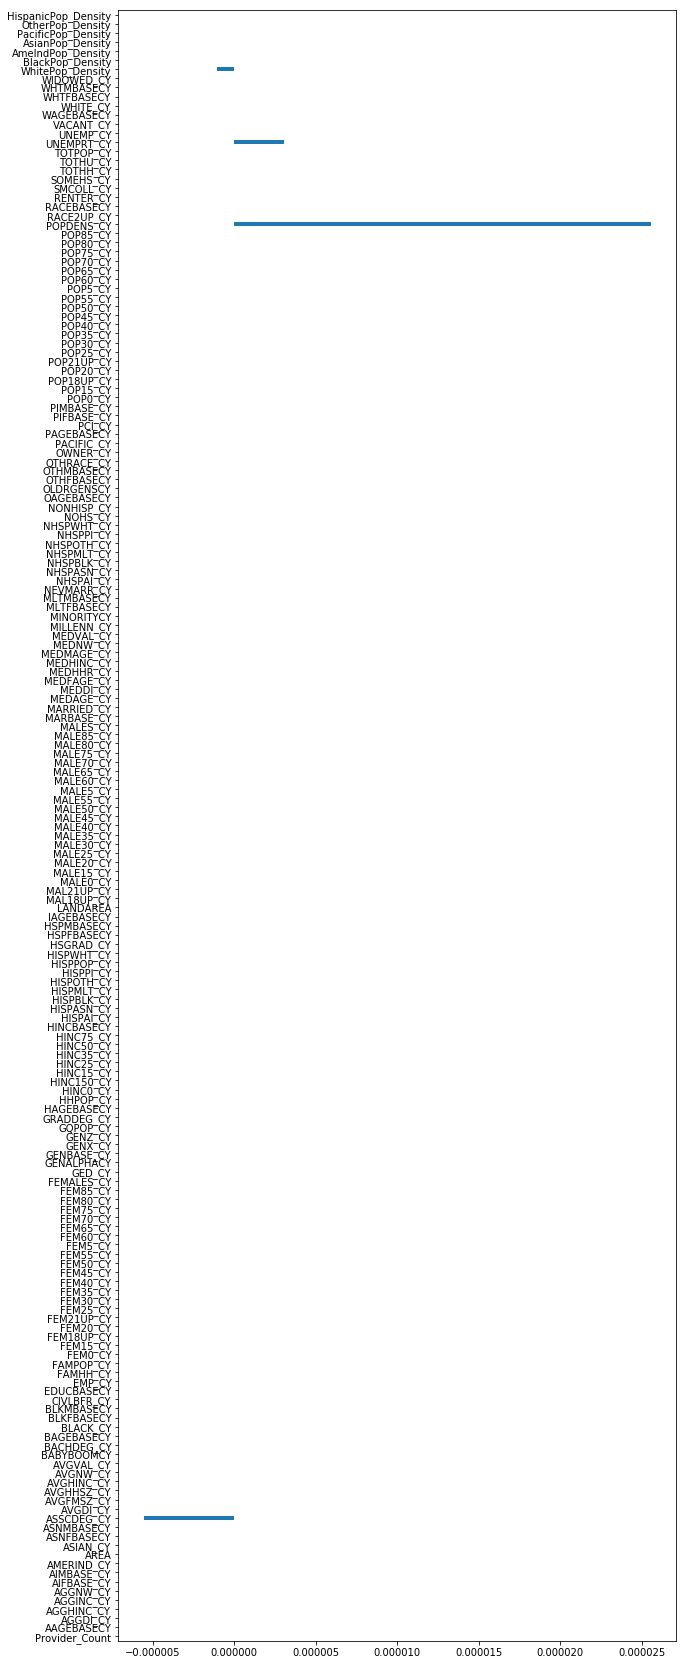

In [157]:
plt.figure(figsize=(10,30))
featureimp = pd.Series(elastic.coef_, index = train_x.columns)
featureimp.plot(kind='barh')
plt.show()